# q3dfit notebook: NIRSPEC, NIR stellar temp

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.0. Setting up the directory tree](#chapter1_0)
    * [1.1. Setting up the data and models](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)
        * [1.2.1. Emission line parameters](#chapter1_2_1)
        * [1.2.2. Continuum parameters](#chapter1_2_2)
    * [1.3. Setting up the plotting parameters](#chapter1_3)
* [2. Run fitting and plotting routines](#chapter2)

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np
%matplotlib inline
# unless you are running this python notebook from the directory where q3dfit is installed, you need to point the
# path to the package in order to import it. 
import sys
sys.path.append("")
sys.path.append("../")

In [2]:
# Convenience function
# Ref: https://github.com/spacetelescope/jwebbinar_prep/blob/main/imaging_mode/imaging_mode_stage_1.ipynb
from astropy.utils.data import download_file
def download_files(files, output_directory, force=False):
    """Given a tuple or list of tuples containing (URL, filename),
    download the given files into the current working directory.
    Downloading is done via astropy's download_file. A symbolic link
    is created in the specified output dirctory that points to the
    downloaded file.
    
    Parameters
    ----------
    files : tuple or list of tuples
        Each 2-tuple should contain (URL, filename), where
        URL is the URL from which to download the file, and
        filename will be the name of the symlink pointing to
        the downloaded file.
        
    output_directory : str
        Name of the directory in which to create the symbolic
        links to the downloaded files
        
    force : bool
        If True, the file will be downloaded regarless of whether
        it is already present or not.
                
    Returns
    -------
    filenames : list
        List of filenames corresponding to the symbolic links
        of the downloaded files
    """
    # In the case of a single input tuple, make it a
    # 1 element list, for consistency.
    filenames = []
    if isinstance(files, tuple):
        files = [files]
        
    for file in files:
        filenames.append(file[1])
        if force:
            print('Downloading {}...'.format(file[1]))
            demo_file = download_file(file[0], cache='update')
            # Make a symbolic link using a local name for convenience
            if not os.path.islink(os.path.join(output_directory, file[1])):
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
        else:
            if not os.path.isfile(os.path.join(output_directory, file[1])):
                print('Downloading {}...'.format(file[1]))
                demo_file = download_file(file[0], cache=True)
                # Make a symbolic link using a local name for convenience
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
            else:
                print('{} already exists, skipping download...'.format(file[1]))
                continue
    return filenames    

### 1.0. Setting up the directory tree <a class="anchor" id="chapter1_0"></a>

Define the directories in which the data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from q3dfit will be saved. Then download test data.

In [3]:
# Base directory (book-keeping)
volume = 'nirspec-nir_stellar/'
# prefix label for output files
gal = 'nirspec-7469'
# Input directory
indir = volume
if not os.path.exists(indir):
    os.makedirs(indir)
# Output directory
outdir = volume
if not os.path.exists(outdir):
    os.makedirs(outdir)
# Initialization file (q3di.npy) directory
initdir = volume
# Output logfile
logfile = outdir+gal+'-fitlog.txt'

Download data from public Box folder:

In [6]:
infile = '/Users/weizheliu/NGC7469/jw01328-o018_t010_nirspec_g140h-f100lp/jw01328-o018_t010_nirspec_g140h-f100lp_s3d.fits'
# make tuples of urls and download filenames
# infile = data cube
#infile_tup=('https://rhodes.box.com/shared/static/vdv7ozrkknvudew4o582qtwcmk08p7w9.fits','nirspec-j1652-conv.fits')
# download files; by default don't force overwrite and take first element of output
#infile = download_files(infile_tup, outdir, force=False)[0]
# add subdirectory to filenames
#infile = outdir+infile

### 1.1. Setting up the data and models <a class="anchor" id="chapter1_1"></a>

Some general information about your cube. `argsreadcube` is a dictionary of attributes sent to the `CUBE` class.
- For non-JWST data, set `wmapext` to `None`. The WMAP extension is a [3-D weight image](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) giving the relative weights of the output spaxels.
- Microns are the wavelength unit used internally, but `q3dfit` can accept other wavelength input units or output other units.
- The code does calculations in flambda space, but assumes input units of MJy/sr, the JWST default. Other input wavelength units can be specified.

In [8]:
from q3dfit.readcube import Cube
argscube = {'wmapext': None, 'pixarea_sqas': 0.0025, 'fluxnorm': 1e-8, 'datext': 1, 'varext': 2, 'dqext': 3}
if not os.path.isfile(infile): 
    print('Data cube not found.')
else:
    cube = Cube(infile, **argscube)
    ncols = cube.ncols # number of columns
    nrows = cube.nrows # number of rows
    cube.about()

Size of data cube: [ 55 , 59 , 3916 ]
Wavelength range: [ 0.9699362933153528 , 1.8899612914375936 ]  micron


Name and systemic redshift of the galaxy. `zsys` is presently not used within the code, but would be an input for, e.g., calculating velocity maps in routines under development (e.g., `makemaps.py`). It is used in this notebook in initializing the arrays of initial guesses below.

In [15]:
name = 'NGC7469'
zsys_gas = 0.016565 #SIMBAD

Wavelength range over which to fit data and the range of wavelength to ignore:

In [16]:
fitrange = [0.98,1.8] #in um
#cutrange = np.array([2.41,2.47])


Generating the quasar template used for PSF subtraction:


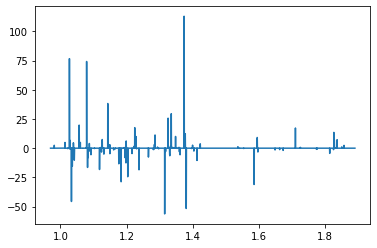

In [17]:
qsotemplate = volume+'nirspec-j1652-quasar-template.npy'
cube.makeqsotemplate(qsotemplate, radius=2.5, norm=50)

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

#### 1.2.1. Emission-line parameters <a class="anchor" id="chapter1_2_1"></a>

What lines do you want to fit? You can choose from the linelists available [here](https://github.com/Q3D/q3dfit/tree/main/data/linelists), or in `q3dfit/data/linelists/`.

In [27]:
lines = ['Pab']

In [28]:
# from q3dfit.jwstlinez import jwstlinez
# from astropy.table import Table, vstack
# configs = ['A', 'B', 'C']
# alltabs = []
# for i in configs:
#     alltabs.append(jwstlinez(zsys, gal, 'NIRSPEC', 'IFU', 'Ch1_'+i))
# alllines = vstack(alltabs)

How many components do you want to be fitted to the emission lines?

In [29]:
maxncomp = 1

This block sets up initial conditions for the emission-line fit to each spaxel. Emission lines are set to a common redshift and velocity dispersion. However, different sets of emission lines can have different velocities and linewidths by specifying different lines to which to tie particular emission lines.

In [30]:
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    #linetie[i] = 'Hbeta'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),zsys_gas)
    siginit_gas[i] = np.full((ncols,nrows,maxncomp),200.)

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [31]:
# Global limit
siglim_gas = np.array([5., 2000.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, 2))
# siglim_gas[:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :] = array([5.,500.])

#### Spectral resolution convolution
##### Just running convolution ---

If no convolution is desired, then set `spectres_convolve` to None. 
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required variables.

Specify the desired convolution method using `spect_instrum`. The syntax is: 
`spect_instrum = {INSTRUMENT:[METHOD]}`, which should mirror the filename in `q3dfit/data/dispersion_files/`. METHOD specifies the grating, spectral resolution [R], Δλ FWHM in [Å], velocity in [km/s].

Examples convolving with: 
1. flat R=500: `spect_instrum = {'flat':['R500']}`
2. flat velocity FWHM = 30km/s: `spect_instrum = {'flat':['kms30']}`
3. flat Δλ FWHM = 4 Å: `spect_instrum = {'flat':['dlambda4']}`
4. JWST NIRSPEC / G140M: `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

If desired flat convolution file does not exist, then a new file will be created automatically. 

In [32]:
#spect_instrum = {'JWST_NIRSPEC':['G235H']}
#spectres_convolve = {'ws_instrum':spect_instrum}
spectres_convolve = None

##### Creating convolution files (optional) ---

If the user wants to create a dispersion file, there are 2 methods:

1. First, run `from q3dfit.common.spectConvol import dispFile` and initialize: `dispObj = dispFile()`
2. Create the files with either method A or B

2.(A) Create a flat R=120 dispersion file from 10 μm to 30 μm: 

`dispObj.make_dispersion(120,WAVELEN=[10,30],TYPE='R')`

2.(B) Create a custom dispersion file with user supplied wavelength and Resolving power lists:

`dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')`

3. Specify desired dispersion file in convolution: running custom example 2B

`spect_instrum = {'custom':['RlistA']}`


In [33]:
#from q3dfit.common.spectConvol import dispFile
#dobj = dispFile()
#dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')
#spect_instrum = {'custom':['RlistA']}

#### 1.2.2 Continuum parameters <a class="anchor" id="chapter1_2_2"></a>

`q3dfit` first masks emission lines before fitting. This sets is the default mask value in km/s for each velocity component for the first fit. During the second fit, the mask value is set automatically using the best-fit linewidths determined from the first fit.

In [34]:
maskwidths_def = 500.

The continuum fitting parameters specified here are for the case of simultaneous fitting of a stellar and quasar template.
- `hostord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `hostord`.
- `qsoord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `qsoord`.
- `qsoxdr` = Filename and path of quasar template created earlier with `makeqsotemplate.py`.

In [35]:
fcncontfit = 'fitqsohost'
argscontfit = dict()
argscontfit['qsoxdr'] = qsotemplate
argscontfit['qsoord'] = 3
argscontfit['hostord'] = 3

### 1.3. Setting up the plotting parameters <a class="anchor" id="chapter1_3"></a>

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [37]:
argspltlin1 = {'nx': 1,
               'ny': 1,
               'line': ['Paa'],
               'size': [0.05, 0.05,0.07]
              }

The continuum plot can be changed by specifying several parameters. In this case, we have chosen to output a linear/linear plot of f$_\lambda$ vs. wavelength, in $\mu$m.

In [38]:
argscontplot = {'xstyle': 'lin',
                'ystyle': 'lin',
                'fluxunit_out': 'flambda',
                'mode': 'dark'}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [20]:
q3di = {# Required pars
        'fcninitpar': 'parinit',
        'fitran': fitrange,
        'fluxunits': 1,
        'infile': infile,
        'label': gal,
        'lines': lines,
        'linetie': linetie,
        'maxncomp': maxncomp,
        'name': gal,
        'ncomp': ncomp,
        'outdir': outdir,
        'zinit_gas': zinit_gas,
        'zsys_gas': zsys_gas,
        # Optional pars
        'datext':0,'varext':1,'dqext':2,
        'argscontfit': argscontfit,
        'argscontplot': argscontplot,
        'argsreadcube': argscube,
        'argspltlin1': argspltlin1,
        #'cutrange': cutrange,
        'decompose_qso_fit': True,
        'fcncontfit': fcncontfit,
        'logfile': logfile,
        'maskwidths_def': maskwidths_def,
        'siglim_gas': siglim_gas,
        'siginit_gas': siginit_gas,
        'spect_convol':spectres_convolve
        }

If you want to run `q3dfit` in batch mode, run this cell, which saves q3di to an `npy` file. In your python command line, read in file and run `q3dfit` with
<pre><code>q3di = '/path/to/the/npy/file/q3di.npy'
from q3dfit.q3df import q3df
q3df(q3di,cols=cols,rows=rows)</code></pre>

In [21]:
q3di_npy = 'q3di.npy'
np.save(initdir+q3di_npy,q3di)

## 2. Run fitting and plotting routines <a class="anchor" id="chapter2"></a>

In [22]:
from q3dfit.q3df import q3df
from q3dfit.q3da import q3da
import q3dfit.q3dpro as q3dpro

Choose columns and rows to fit. Ranges are specified as two-element lists specifying the first and last spaxel.

In [23]:
cols = 50
rows = 40
cc = np.arange(1,88)
rr = np.arange(1,80)
# cc = np.arange(45,55)
# rr = np.arange(40,41)

Run the fit. Choose `quiet=False` for verbose output. An output dictionary for each spaxel is saved to a numpy binary file labeled with prefix `q3di['label']` and suffix `_col_row.npy`.

In [24]:
#q3df(q3di,cols=cols,rows=rows, quiet=False)
#q3df(q3di, quiet=False)
for cols in cc:
   for rows in rr:
       #break
       q3df(initdir+q3di_npy,cols=cols,rows=rows, quiet=True,ncores=10)

0
0
0
0
0
0
0
0
0
1
0 0
0
0
0
0
0
0
0
0
0
1
0 1
0
0
1
0 2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0 3
0
0
0
0
0
0
0
0
0
0
1
0 4
0
0
0
1
0 5
0
0
0
0
0
0
0
0
0
1
0 6
0
0
0
0
0
0
0
0
0
0
0
1
0 7
0
0
0
0
0
1
0 8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0 9
0
0
1
0 10
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0 11
0
0
0
0
0
0
0
0
0
0
0
1
0 12
0
0
0
0
0
0
0
0
0
1
0 13
0
0
1
0 14
0
0
0
0
0
0
0
0
0
0
1
0 15
0
0
0
0
0
0
0
0
0
1
0 16
0
0
0
0
0
0
0
0
1
0 17
0
0
0
0
0
0
0
0
1
0 18
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0 19
0
0
0
1
0 20
0
0
0
0
0
0
0
0
0
0
0
1
0 21
0
0
0
0
0
0
0
0
0
1
0 22
0
0
0
0
0
0
0
0
1
0 23
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0 24
0
0
0
0
0
0
1
0 25
0
0
0
0
0
0
1
0 26
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0 27
0
0
0
0
0
0
0
0
1
0 28
0
0
0
0
1
0 29
0
0
0
0
0
0
0
0
1
0 30
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0 31
0
0
0
0
0
0
0
0
1
0 32
0
0
0
1
0 33
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0 34
0
0
0
0
0
0
0
0
0
0
0
0
1
0 35
0
0
0
0
0
0
1
0 36
0
0
0
0
0
0
0
0
0
0
1
0 37
0
0
0
0
0
0
0
0
1
0 38
0
0
0
0
0
0
1
0 39
0
0
0
0
0
0
0
0
0
0
1


Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x0000000101c19a1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x0000000101bc2678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x0000000101c01bf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x0000000101bc59d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x0000000101befb8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x0000000100d99ce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x0000000100cc47d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x000000010034bad8 call_ll_exitfuncs + 96
8   python3.9                           0x000000010034b7ac Py_FinalizeEx + 228
9   python3.9                           0x0000000100375eec Py_RunMain + 44
10  python3.9                           0x00000

1
1 46
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1 47
0
0
0
0
0
0
0
0
0
0
0
1
1 48
0
0
0
0
0
1
1 49
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1 50
0
0
0
0
0
0
0
0
0
1
1 51
0
1
1 52
0
0
0
0
0
0
0
0
0
1
1 53
0
0
0
0
0
0
0
0


Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x00000001064f9a1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x00000001064a2678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x00000001064e1bf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x00000001064a59d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x00000001064cfb8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x0000000106049ce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x00000001057687d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x0000000104c63ad8 call_ll_exitfuncs + 96
8   python3.9                           0x0000000104c637ac Py_FinalizeEx + 228
9   python3.9                           0x0000000104c8deec Py_RunMain + 44
10  python3.9                           0x00000

0
0
0
1
1 54
0
0
0
0
0
0
0
0
0
0
0
1
1 55
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1 56
0
0
0
0
0
0
0
0
1
1 57
0
0
0
0
0
1
1 58
0
0
0
0
0
1
1 59
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1 60
0
0
0
0
0
0
0
0
1
1 61
0
0
0
0
0
0
0
0
0
0
1
1 62
0
0
0
0
0
0
0
0
0
0
1
1 63
0
0
1
1 64
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1 65
0
0
0
0
0
0
0
0
0
0
0
1
1 66
0
0
0
0
0
0
0
0
0
1
1 67
0
0
0
0
0
1
1 68
0
0
0
0
0
0
0
0
0
0
0
1
1 69
0
0
0
0
0
0
0
0
1
1 70
0
0
0
0
0
0
1
1 71
0
0
0
0
0
0
0
0
0
0
0
1
1 72
0
0
0
0
1
1 73
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1 74
0
0
0
0
0
0
0
0
0
0
0
0
1
1 75
0
0
1
1 76
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1 77
0
0
0
0
0
0
0
0
0
0
0
1
1 78
0
0
0
0
0
0
0
0
0
1
2 0
0
0
0
0
0
0
0
0
1
2 1
0
1
2 2
0
0
0
0
0
0
0
0
0
0
1
2 3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2 4
0
0
0
0
0
0
0
0
1
2 5
0
0
0
0
0
0
0
0
0
0
1
2 6
0
0
0
1
2 7
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2 8
0
0
0
0
0
0
1
2 9
0
0
0
0
0
0
0
0
0
0
1
2 10
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2 11
0
0
0
0
0
0
0
1
2 12
0
0
0
1
2 13
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2 14
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 490, in fitspec
    gdflux_nocnt_sm = savgol_filter(gdflux_nocnt, 11, 3)
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_savitzky_golay.py", line 339, in savgol_filter
    raise ValueError("If mode is 'interp', window_length must be l

1
4 26
0
0
0
0
0
0
0
0
0
1
4 27


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 490, in fitspec
    gdflux_nocnt_sm = savgol_filter(gdflux_nocnt, 11, 3)
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_savitzky_golay.py", line 339, in savgol_filter
    raise ValueError("If mode is 'interp', window_length must be l

0
0
0
0
0
0
0
0
0
1
4 28
0
0
0
0
0
0
0
0
0
1
4 29
0
0
0
0
0
0
0
0
0
1
4 30
0
0
0
0
0
0
0
0
0
1
4 31
0
0
0
0
0
0
0
0
0
1
4 32
0
0
0
0
0
0
0
0
0
1
4 33
0
0
0
0
0
0
0
0
0
1
4 34
0
0
0
0
0
0
0
0
0
1
4 35
0
0
0
0
0
0
0
0
0
1
4 36
0
0
0
0
0
0
0
0
0
1
4 37
1
4 38
0
0
0
0
0
0
0
0
0
0
1
4 39
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
4 40
0
0
0
0
0
0
0
0
0
1
4 41
0
0
0
0
0
0
0
0
0
1
4 42
0
0
0
0
0
0
0
0
0
1
4 43
0
0
0
0
0
0
0
0
0
1
4 44
0
0
0
0
0
0
0
0
0
1
4 45
0
0
0
0
0
0
0
0
0
1
4 46
0
0
0
0
0
0
0
0
0
1
4 47
0
0
0
0
0
0
0
0
0
1
4 48
0
0
0
0
0
0
0
0
0
1
4 49
0
0
0
0
0
0
0
0
1
4 50
0
0
0
0
0
0
0
0
0
0
1
4 51
0
1
4 52
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
4 53
0
0
0
0
0
0
0
0
0
1
4 54
0
0
0
0
0
0
0
0
0
1
4 55
0
0
0
0
0
0
0
0
0
1
4 56
0
0
0
0
0
0
0
0
0
1
4 57
0
0
0
0
0
0
0
0
0
1
4 58
0
0
0
0
0
0
0
0
0
1
4 59
0
0
0
0
0
0
0
0
0
1
4 60
0
0
0
0
0
0
0
0
0
1
4 61
0
0
0
0
0
0
0
0
0
1
4 62
0
0
0
0
0
0
0
0
0
1
4 63
0
0
0
0
0
0
0
0
0
1
4 64
0
0
0
0
0
0
0
0
0
1
4 65
0
0
0
0
0
0
0
0
0
1
4 66
0
0
0
0
0
0
0
0
0
1
4 67


Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x0000000105e71a1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x0000000105e1a678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x0000000105e59bf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x0000000105e1d9d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x0000000105e47b8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x00000001059c1ce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x00000001058ec7d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x0000000104f73ad8 call_ll_exitfuncs + 96
8   python3.9                           0x0000000104f737ac Py_FinalizeEx + 228
9   python3.9                           0x0000000104f9deec Py_RunMain + 44
10  python3.9                           0x00000

0
0
0
0
0
0
0
0
0
1
4 78
0
0
1
5 0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
5 1
0
0
0
0
0
0
0
0
0
1
5 2
0
0
0
0
1
5 3
0
0
0
0
0
0
0
0
0
1
5 4
0
0
0
0
0
0
0
0
0
0
0
0
0
1
5 5
0
0
0
0
0
0
0
0
1
5 6
0
0
0
0
0
0
1
5 7
0
0
0
0
0
0
0
1
5 8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
5 9
0
0
0
0
0
0
0
0
1
5 10
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 211, in fitspec
    gdflux_log, gdlambda_log, velscale = log_rebin(fitran, gdflux)
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/ppxf/ppxf_util.py", line 127, in log_rebin
    assert np.all(np.diff(lam) > 0), '`lam` must be monotonically increasi

1
5 11
0
0
0
0
0
0
0
0
0
0
0
1
5 12
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
5 13
0
0
0
0
0
0
0
0
0
1
5 14
0
0
0
0
0
0
0
0
0
1
5 15
0
0
0
0
0
0
0
0
0
1
5 16
0
0
0
0
0
0
0
0
0
1
5 17
0
0
0
0
0
0
0
0
0
1
5 18
0
0
0
0
0
0
0
0
0
1
5 19
0
0
0
0
0
0
0
0
0
1
5 20
0
0
0
0
0
0
0
0
0
1
5 21
0
0
0
0
0
0
0
0
0
1
5 22
0
0
0
0
0
0
0
0
0
1
5 23
0
0
0
0
0
0
0
0
0
1
5 24
0
0
0
0
0
0
0
0
0
1
5 25
0
0
0
0
0
0
0
0
0
1
5 26
0
0
0
0
0
0
0
0
0
1
5 27
0
0
0
0
0
0
0
0
0
1
5 28
0
0
0
0
0
0
0
0
0
1
5 29
0
0
0
0
0
0
0
0
0
1
5 30
0
0
0
0
0
0
0
0
0
1
5 31
0
0
0
0
0
0
0
0
0
1
5 32
0
0
0
0
0
0
0
0
0
1
5 33
0
0
0
0
0
0
0
0
0
1
5 34
0
0
0
0
0
0
0
0
0
1
5 35
0
0
0
0
0
0
0
0
0
1
5 36
0
0
0
0
0
0
0
0
0
1
5 37
0
0
0
0
0
0
0
0
0
1
5 38
0
0
0
0
0
0
0
0
0
1
5 39
0
0
0
0
0
0
0
0
0
1
5 40
0
0
0
0
0
0
0
0
0
1
5 41
0
0
0
0
0
0
0
0
0
1
5 42
0
0
0
0
0
0
0
0
0
1
5 43
0
0
0
0
0
0
0
0
0
1
5 44
0
0
0
0
0
0
0
0
0
1
5 45
0
0
0
0
0
0
0
0
0
1
5 46
0
0
0
0
0
0
0
0
0
1
5 47
0
0
0
0
0
0
0
0
0
1
5 48
0
0
0
0
0
0
0
0
0
1
5 49
0
0
0
0
0
0
0
0
0
1
5 50
0


Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x00000001055d5a1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x000000010557e678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x00000001055bdbf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x00000001055819d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x00000001055abb8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x0000000105125ce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x00000001050507d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x00000001046c3ad8 call_ll_exitfuncs + 96
8   python3.9                           0x00000001046c37ac Py_FinalizeEx + 228
9   python3.9                           0x00000001046edeec Py_RunMain + 44
10  python3.9                           0x00000

0
0
0
0
0
0
0
0
1
6 0
0
0
0
0
0
1
6 1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
6 2
0
0
0
0
1
6 3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
6 4
0
0
0
0
0
0
0
0
0
0
1
6 5
0
0
0
1
6 6
0
0
0
0
0
0
0
0
0
0
0
1
6 7
0
0
0
0
0
1
6 8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
6 9
0
0
0
0
0
0
0
0
0
0
0
1
6 10
0
0
0
0
0
0
0
0
0
1
6 11
0
0
0
0
0
0
0
0
0
1
6 12
0
0
0
0
0
0
0
0
0
1
6 13
0
0
0
0
0
0
0
0
0
1
6 14
0
0
0
0
0
0
0
0
0
1
6 15
0
0
0
0
0
0
0
0
0
1
6 16
0
0
0
0
0
0
0
0
0
1
6 17
0
0
0
0
0
0
0
0
0
1
6 18
0
0
0
0
0
0
0
0
0
1
6 19
0
0
0
0
0
0
0
0
0
1
6 20
0
0
0
0
0
0
0
0
0
1
6 21
0
0
0
0
0
0
0
0
0
1
6 22
0
0
0
0
0
0
0
0
0
1
6 23
0
0
0
0
0
0
0
0
0
1
6 24
0
0
0
0
0
0
0
0
0
1
6 25
0
0
0
0
0
0
0
0
0
1
6 26
0
0
0
0
0
0
0
0
0
1
6 27
0
0
0
0
0
0
0
0
0
1
6 28
0
0
0
0
0
0
0
0
0
1
6 29
0
0
0
0
0
0
0
0
0
1
6 30
0
0
0
0
0
0
0
0
0
1
6 31
0
0
0
0
0
0
0
0
0
1
6 32
0
0
0
0
0
0
0
0
0
1
6 33
0
0
0
0
0
0
0
0
0
1
6 34
0
0
0
0
0
0
0
0
0
1
6 35
0
0
0
0
0
0
0
0
0
1
6 36
0
0
0
0
0
0
0
0
0
1
6 37
0
0
0
0
0
0
0
0
0
1
6 38
0
0
0
0
0
0
0
0
0
1
6 39
0
0
0
0
0


Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x0000000101129a1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x00000001010d2678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x0000000101111bf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x00000001010d59d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x00000001010ffb8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x0000000100c79ce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x0000000100ba47d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x0000000100217ad8 call_ll_exitfuncs + 96
8   python3.9                           0x00000001002177ac Py_FinalizeEx + 228
9   python3.9                           0x0000000100241eec Py_RunMain + 44
10  python3.9                           0x00000

0
0
0
0
0
0
0
0
0
1
8 31
0
0
0
0
0
0
0
0
0
1
8 32
0
0
0
0
0
0
0
0
0
1
8 33
0
0
0
0
0
0
0
0
0
1
8 34
0
0
0
0
0
0
0
0
0
1
8 35
0
0
0
0
0
0
0
0
0
1
8 36
0
0
0
0
0
0
0
0
0
1
8 37
0
0
0
0
0
0
0
0
0
1
8 38
0
0
0
0
0
0
0
0
0
1
8 39
0
0
0
0
0
0
0
0
0
1
8 40
0
0
0
0
0
0
0
0
0
1
8 41
0
0
0
0
0
0
0
0
0
1
8 42
0
0
0
0
0
0
0
0
0
1
8 43
0
0
0
0
0
0
0
0
0
1
8 44
0
0
0
0
0
0
0
0
0
1
8 45
0
0
0
0
0
0
0
0
0
1
8 46
0
0
0
0
0
0
0
0
0
1
8 47
0
0
0
0
0
0
0
0
0
1
8 48
0
0
0
0
0
0
0
0
0
1
8 49
0
0
0
0
0
0
0
0
0
1
8 50
0
0
0
0
0
0
0
0
0
1
8 51
0
0
0
0
0
0
0
0
0
1
8 52
0
0
0
0
0
0
0
0
0
1
8 53
0
0
0
0
0
0
0
0
0
1
8 54
0
0
0
0
0
0
0
0
0
1
8 55
0
0
0
0
0
0
0
0
0
1
8 56
0
0
0
0
0
0
0
0
0
1
8 57
0
0
0
0
0
0
0
0
0
1
8 58
0
0
0
0
0
0
0
0
0
1
8 59
0
0
0
0
0
0
0
0
0
1
8 60
0
0
0
0
0
0
0
0
0
1
8 61
0
0
0
0
0
0
0
0
0
1
8 62
0
0
0
0
0
0
0
0
0
1
8 63
0
0
0
0
0
0
0
0
0
1
8 64
0
0
0
0
0
0
0
0
0
1
8 65
0
0
0
0
0
0
0
0
0
1
8 66
0
0
0
0
0
0
0
0
0
1
8 67
0
0
0
0
0
0
0
0
0
1
8 68
0
0
0
0
0
0
0
0
0
1
8 69
0
0
0
0
0
0
0
0
0
1
8 70


Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x0000000105141a1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x00000001050ea678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x0000000105129bf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x00000001050ed9d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x0000000105117b8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x0000000104c91ce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x0000000104bbc7d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x0000000104237ad8 call_ll_exitfuncs + 96
8   python3.9                           0x00000001042377ac Py_FinalizeEx + 228
9   python3.9                           0x0000000104261eec Py_RunMain + 44
10  python3.9                           0x00000

0
0
0
0
0
0
0
0
0
1
10 5
0
0
0
0
0
0
0
0
0
1
10 6
0
0
0
0
0
0
0
0
0
1
10 7
0
0
0
0
0
0
0
0
0
1
10 8
0
0
0
0
0
0
0
0
0
1
10 9
0
0
0
0
0
0
0
0
0
1
10 10
0
0
0
0
0
0
0
0
0
1
10 11
0
0
0
0
0
0
0
0
0
1
10 12
0
0
0
0
0
0
0
0
0
1
10 13
0
0
0
0
0
0
0
0
0
1
10 14
0
0
0
0
0
0
0
0
0
1
10 15
0
0
0
0
0
0
0
0
0
1
10 16
0
0
0
0
0
0
0
0
0
1
10 17
0
0
0
0
0
0
0
0
0
1
10 18
0
0
0
0
0
0
0
0
0
1
10 19
0
0
0
0
0
0
0
0
0
1
10 20
0
0
0
0
0
0
0
0
0
1
10 21
0
0
0
0
0
0
0
0
0
1
10 22
0
0
0
0
0
0
0
0
0
1
10 23
0
0
0
0
0
0
0
0
0
1
10 24
0
0
0
0
0
0
0
0
0
1
10 25
0
0
0
0
0
0
0
0
0
1
10 26
0
0
0
0
0
0
0
0
0
1
10 27
0
0
0
0
0
0
0
0
0
1
10 28
0
0
0
0
0
0
0
0
0
1
10 29
0
0
0
0
0
0
0
0
0
1
10 30
0
0
0
0
0
0
0
0
0
1
10 31
0
0
0
0
0
0
0
0
0
1
10 32
0
0
0
0
0
0
0
0
0
1
10 33
0
0
0
0
0
0
0
0
0
1
10 34
0
0
0
0
0
0
0
0
0
1
10 35
0
0
0
0
0
0
0
0
0
1
10 36
0
0
0
0
0
0
0
0
0
1
10 37
0
0
0
0
0
0
0
0
0
1
10 38
0
0
0
0
0
0
0
0
0
1
10 39
0
0
0
0
0
0
0
0
0
1
10 40
0
0
0
0
0
0
0
0
0
1
10 41
0
0
0
0
0
0
0
0
0
1
10 42
0
0
0
0
0
0
0
0
0

1
14 5
0
0
0
0
0
0
0
0
0
1
14 6
0
0
0
0
0
0
0
0
0
1
14 7
0
0
0
0
0
0
0
0
0
1
14 8
0
0
0
0
0
0
0
0
0
1
14 9
0
0
0
0
0
0
0
0
0
1
14 10
0
0
0
0
0
0
0
0
0
1
14 11
0
0
0
0
0
0
0
0
0
1
14 12
0
0
0
0
0
0
0
0
0
1
14 13
0
0
0
0
0
0
0
0
0
1
14 14
0
0
0
0
0
0
0
0
0
1
14 15
0
0
0
0
0
0
0
0
0
1
14 16
0
0
0
0
0
0
0
0
0
1
14 17
0
0
0
0
0
0
0
0
0
1
14 18
0
0
0
0
0
0
0
0
0
1
14 19
0
0
0
0
0
0
0
0
0
1
14 20
0
0
0
0
0
0
0
0
0
1
14 21
0
0
0
0
0
0
0
0
0
1
14 22
0
0
0
0
0
0
0
0
0
1
14 23
0
0
0
0
0
0
0
0
0
1
14 24
0
0
0
0
0
0
0
0
0
1
14 25
0
0
0
0
0
0
0
0
0
1
14 26
0
0
0
0
0
0
0
0
0
1
14 27
0
0
0
0
0
0
0
0
0
1
14 28
0
0
0
0
0
0
0
0
0
1
14 29
0
0
0
0
0
0
0
0
0
1
14 30
0
0
0
0
0
0
0
0
0
1
14 31
0
0
0
0
0
0
0
0
0
1
14 32
0
0
0
0
0
0
0
0
0
1
14 33
0
0
0
0
0
0
0
0
0
1
14 34
0
0
0
0
0
0
0
0
0
1
14 35
0
0
0
0
0
0
0
0
0
1
14 36
0
0
0
0
0
0
0
0
0
1
14 37
0
0
0
0
0
0
0
0
0
1
14 38
0
0
0
0
0
0
0
0
0
1
14 39
0
0
0
0
0
0
0
0
0
1
14 40
0
0
0
0
0
0
0
0
0
1
14 41
0
0
0
0
0
0
0
0
0
1
14 42
0
0
0
0
0
0
0
0
0
1
14 43
0
0
0
0
0

1
18 6
0
0
0
0
0
0
0
0
0
1
18 7
0
0
0
0
0
0
0
0
0
1
18 8
0
0
0
0
0
0
0
0
0
1
18 9
0
0
0
0
0
0
0
0
0
1
18 10
0
0
0
0
0
0
0
0
0
1
18 11
0
0
0
0
0
0
0
0
0
1
18 12
0
0
0
0
0
0
0
0
0
1
18 13
0
0
0
0
0
0
0
0
0
1
18 14
0
0
0
0
0
0
0
0
0
1
18 15
0
0
0
0
0
0
0
0
0
1
18 16
0
0
0
0
0
0
0
0
0
1
18 17
0
0
0
0
0
0
0
0
0
1
18 18
0
0
0
0
0
0
0
0
0
1
18 19
0
0
0
0
0
0
0
0
0
1
18 20
0
0
0
0
0
0
0
0
0
1
18 21
0
0
0
0
0
0
0
0
0
1
18 22
0
0
0
0
0
0
0
0
0
1
18 23
0
0
0
0
0
0
0
0
0
1
18 24
0
0
0
0
0
0
0
0
0
1
18 25
0
0
0
0
0
0
0
0
0
1
18 26
0
0
0
0
0
0
0
0
0
1
18 27
0
0
0
0
0
0
0
0
0
1
18 28
0
0
0
0
0
0
0
0
0
1
18 29
0
0
0
0
0
0
0
0
0
1
18 30
0
0
0
0
0
0
0
0
0
1
18 31
0
0
0
0
0
0
0
0
0
1
18 32
0
0
0
0
0
0
0
0
0
1
18 33
0
0
0
0
0
0
0
0
0
1
18 34
0
0
0
0
0
0
0
0
0
1
18 35
0
0
0
0
0
0
0
0
0
1
18 36
0
0
0
0
0
0
0
0
0
1
18 37
0
0
0
0
0
0
0
0
0
1
18 38
0
0
0
0
0
0
0
0
0
1
18 39
0
0
0
0
0
0
0
0
0
1
18 40
0
0
0
0
0
0
0
0
0
1
18 41
0
0
0
0
0
0
0
0
0
1
18 42
0
0
0
0
0
0
0
0
0
1
18 43
0
0
0
0
0
0
0
0
0
1
18 44
0
0
0
0


1
22 7
0
0
0
0
0
0
0
0
0
1
22 8
0
0
0
0
0
0
0
0
0
1
22 9
0
0
0
0
0
0
0
0
0
1
22 10
0
0
0
0
0
0
0
0
0
1
22 11
0
0
0
0
0
0
0
0
0
1
22 12
0
0
0
0
0
0
0
0
0
1
22 13
0
0
0
0
0
0
0
0
0
1
22 14
0
0
0
0
0
0
0
0
0


Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x0000000105c19a1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x0000000105bc2678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x0000000105c01bf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x0000000105bc59d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x0000000105befb8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x0000000104cedce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x0000000104c187d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x0000000104297ad8 call_ll_exitfuncs + 96
8   python3.9                           0x00000001042977ac Py_FinalizeEx + 228
9   python3.9                           0x00000001042c1eec Py_RunMain + 44
10  python3.9                           0x00000

0
0
0
0
0
0
0
0
0
1
22 16
0
0
0
0
0
0
0
0
0
1
22 17
0
0
0
0
0
0
0
0
0
1
22 18
0
0
0
0
0
0
0
0
0
1
22 19
0
0
0
0
0
0
0
0
0
1
22 20
0
0
0
0
0
0
0
0
0
1
22 21
0
0
0
0
0
0
0
0
0
1
22 22
0
0
0
0
0
0
0
0
0
1
22 23
0
0
0
0
0
0
0
0
0
1
22 24
0
0
0
0
0
0
0
0
0
1
22 25
0
0
0
0
0
0
0
0
0
1
22 26
0
0
0
0
0
0
0
0
0
1
22 27
0
0
0
0
0
0
0
0
0
1
22 28
0
0
0
0
0
0
0
0
0
1
22 29
0
0
0
0
0
0
0
0
0
1
22 30
0
0
0
0
0
0
0
0
0
1
22 31
0
0
0
0
0
0
0
0
0
1
22 32
0
0
0
0
0
0
0
0
0
1
22 33
0
0
0
0
0
0
0
0
0
1
22 34
0
0
0
0
0
0
0
0
0
1
22 35
0
0
0
0
0
0
0
0
0
1
22 36
0
0
0
0
0
0
0
0
0
1
22 37
0
0
0
0
0
0
0
0
0
1
22 38
0
0
0
0
0
0
0
0
0
1
22 39
0
0
0
0
0
0
0
0
0
1
22 40
0
0
0
0
0
0
0
0
0
1
22 41
0
0
0
0
0
0
0
0
0
1
22 42
0
0
0
0
0
0
0
0
0
1
22 43
0
0
0
0
0
0
0
0
0
1
22 44
0
0
0
0
0
0
0
0
0
1
22 45
0
0
0
0
0
0
0
0
0
1
22 46
0
0
0
0
0
0
0
0
0
1
22 47
0
0
0
0
0
0
0
0
0
1
22 48
0
0
0
0
0
0
0
0
0
1
22 49
0
0
0
0
0
0
0
0
0
1
22 50
0
0
0
0
0
0
0
0
0
1
22 51
0
0
0
0
0
0
0
0
0
1
22 52
0
0
0
0
0
0
0
0
0
1
22 53
0
0
0
0
0
0


1
26 16
0
0
0
0
0
0
0
0
0
1
26 17
0
0
0
0
0
0
0
0
0
1
26 18
0
0
0
0
0
0
0
0
0
1
26 19
0
0
0
0
0
0
0
0
0
1
26 20
0
0
0
0
0
0
0
0
0
1
26 21
0
0
0
0
0
0
0
0
0
1
26 22
0
0
0
0
0
0
0
0
0
1
26 23
0
0
0
0
0
0
0
0
0
1
26 24
0
0
0
0
0
0
0
0
0
1
26 25
0
0
0
0
0
0
0
0
0
1
26 26
0
0
0
0
0
0
0
0
0
1
26 27
0
0
0
0
0
0
0
0
0
1
26 28
0
0
0
0
0
0
0
0
0
1
26 29
0
0
0
0
0
0
0
0
0
1
26 30
0
0
0
0
0
0
0
0
0
1
26 31
0
0
0
0
0
0
0
0
0
1
26 32
0
0
0
0
0
0
0
0
0
1
26 33
0
0
0
0
0
0
0
0
0
1
26 34
0
0
0
0
0
0
0
0
0
1
26 35
0
0
0
0
0
0
0
0
0
1
26 36
0
0
0
0
0
0
0
0
0
1
26 37
0
0
0
0
0
0
0
0
0
1
26 38
0
0
0
0
0
0
0
0
0
1
26 39
0
0
0
0
0
0
0
0
0
1
26 40
0
0
0
0
0
0
0
0
0
1
26 41
0
0
0
0
0
0
0
0
0
1
26 42
0
0
0
0
0
0
0
0
0
1
26 43
0
0
0
0
0
0
0
0
0
1
26 44
0
0
0
0
0
0
0
0
0
1
26 45
0
0
0
0
0
0
0
0
0
1
26 46
0
0
0
0
0
0
0
0
0
1
26 47
0
0
0
0
0
0
0
0
0
1
26 48
0
0
0
0
0
0
0
0
0
1
26 49
0
0
0
0
0
0
0
0
0
1
26 50
0
0
0
0
0
0
0
0
0
1
26 51
0
0
0
0
0
0
0
0
0
1
26 52
0
0
0
0
0
0
0
0
0
1
26 53
0
0
0
0
0
0
0
0
0
1
26 54
0
0


Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x00000001032a5a1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x000000010324e678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x000000010328dbf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x00000001032519d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x000000010327bb8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x0000000102df5ce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x0000000102d207d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x00000001023a7ad8 call_ll_exitfuncs + 96
8   python3.9                           0x00000001023a77ac Py_FinalizeEx + 228
9   python3.9                           0x00000001023d1eec Py_RunMain + 44
10  python3.9                           0x00000

0
0
0
0
0
0
0
0
0
1
27 60
0
0
0
0
0
0
0
0
0
1
27 61
0
0
0
0
0
0
0
0
0
1
27 62
0
0
0
0
0
0
0
0
0
1
27 63
0
0
0
0
0
0
0
0
0
1
27 64
0
0
0
0
0
0
0
0
0
1
27 65
0
0
0
0
0
0
0
0
0
1
27 66
0
0
0
0
0
0
0
0
0
1
27 67
0
0
0
0
0
0
0
0
0
1
27 68
0
0
0
0
0
0
0
0
0
1
27 69
0
0
0
0
0
0
0
0
0
1
27 70
0
0
0
0
0
0
0
0
0
1
27 71
0
0
0
0
0
0
0
0
0
1
27 72
0
0
0
0
0
0
0
0
0
1
27 73
0
0
0
0
0
0
0
0
0
1
27 74
0
0
0
0
0
0
0
0
0
1
27 75
0
0
0
0
0
1
27 76
0
0
0
0
0
0
0
0
0
0
0
0
0
1
27 77
0
1
27 78
0
0
0
0
0
0
0
0
0
0
0
1
28 0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
28 1
0
0
0
0
0
1
28 2
0
0
0
0
0
0
0
0
0
0
0
0
1
28 3
0
0
0
0
0
0
0
0
0
0
1
28 4
0
0
0
0
0
0
0
0
0
1
28 5
0
0
0
0
0
0
0
0
0
1
28 6
0
0
0
0
0
0
0
0
0
1
28 7
0
0
0
0
0
0
0
0
0
1
28 8
0
0
0
0
0
0
0
0
0
1
28 9
0
0
0
0
0
0
0
0
0
1
28 10
0
0
0
0
0
0
0
0
0
1
28 11
0
0
0
0
0
0
0
0
0
1
28 12
0
0
0
0
0
0
0
0
0
1
28 13
0
0
0
0
0
0
0
0
0
1
28 14
0
0
0
0
0
0
0
0
0
1
28 15
0
0
0
0
0
0
0
0
0
1
28 16
0
0
0
0
0
0
0
0
0
1
28 17
0
0
0
0
0
0
0
0
0
1
28 18
0
0
0
0
0
0
0
0
0
1
28

Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x0000000105835a1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x00000001057de678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x000000010581dbf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x00000001057e19d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x000000010580bb8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x0000000105385ce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x00000001052b07d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x0000000104937ad8 call_ll_exitfuncs + 96
8   python3.9                           0x00000001049377ac Py_FinalizeEx + 228
9   python3.9                           0x0000000104961eec Py_RunMain + 44
10  python3.9                           0x00000

0
0
0
0
0
0
0
0
0
1
29 34
0
0
0
0
0
0
0
0
0
1
29 35
0
0
0
0
0
0
0
0
0
1
29 36
0
0
0
0
0
0
0
0
0
1
29 37
0
0
0
0
0
0
0
0
0
1
29 38
0
0
0
0
0
0
0
0
0
1
29 39
0
0
0
0
0
0
0
0
0
1
29 40
0
0
0
0
0
0
0
0
0
1
29 41
0
0
0
0
0
0
0
0
0
1
29 42
0
0
0
0
0
0
0
0
0
1
29 43
0
0
0
0
0
0
0
0
0
1
29 44
0
0
0
0
0
0
0
0
0
1
29 45
0
0
0
0
0
0
0
0
0
1
29 46
0
0
0
0
0
0
0
0
0
1
29 47
0
0
0
0
0
0
0
0
0
1
29 48
0
0
0
0
0
0
0
0
0
1
29 49
0
0
0
0
0
0
0
0
0
1
29 50
0
0
0
0
0
0
0
0
0
1
29 51
0
0
0
0
0
0
0
0
0
1
29 52
0
0
0
0
0
0
0
0
0
1
29 53
0
0
0
0
0
0
0
0
0
1
29 54
0
0
0
0
0
0
0
0
0
1
29 55
0
0
0
0
0
0
0
0
0
1
29 56
0
0
0
0
0
0
0
0
0
1
29 57
0
0
0
0
0
0
0
0
0
1
29 58
0
0
0
0
0
0
0
0
0
1
29 59
0
0
0
0
0
0
0
0
0
1
29 60
0
0
0
0
0
0
0
0
0
1
29 61
0
0
0
0
0
0
0
0
0
1
29 62
0
0
0
0
0
0
0
0
0
1
29 63
0
0
0
0
0
0
0
0
0
1
29 64
0
0
0
0
0
0
0
0
0
1
29 65
0
0
0
0
0
0
0
0
0
1
29 66
0
0
0
0
0
0
0
0
0
1
29 67
0
0
0
0
0
0
0
0
0
1
29 68
0
0
0
0
0
0
0
0
0
1
29 69
0
0
0
0
0
0
0
0
0
1
29 70
0
0
0
0
0
0
0
0
0
1
29 71
0
0
0
0
0
0


1
33 34
0
0
0
0
0
0
0
0
0
1
33 35
0
0
0
0
0
0
0
0
0
1
33 36
0
0
0
0
0
0
0
0
0
1
33 37
0
0
0
0
0
0
0
0
0
1
33 38
0
0
0
0
0
0
0
0
0
1
33 39
0
0
0
0
0
0
0
0
0
1
33 40
0
0
0
0
0
0
0
0
0
1
33 41
0
0
0
0
0
0
0
0
0
1
33 42
0
0
0
0
0
0
0
0
0
1
33 43
0
0
0
0
0
0
0
0
0
1
33 44
0
0
0
0
0
0
0
0
0
1
33 45
0
0
0
0
0
0
0
0
0
1
33 46
0
0
0
0
0
0
0
0
0
1
33 47
0
0
0
0
0
0
0
0
0
1
33 48
0
0
0
0
0
0
0
0
0
1
33 49
0
0
0
0
0
0
0
0
0
1
33 50
0
0
0
0
0
0
0
0
0
1
33 51
0
0
0
0
0
0
0
0
0
1
33 52
0
0
0
0
0
0
0
0
0
1
33 53
0
0
0
0
0
0
0
0
0
1
33 54
0
0
0
0
0
0
0
0
0
1
33 55
0
0
0
0
0
0
0
0
0
1
33 56
0
0
0
0
0
0
0
0
0
1
33 57
0
0
0
0
0
0
0
0
0
1
33 58
0
0
0
0
0
0
0
0
0
1
33 59
0
0
0
0
0
0
0
0
0
1
33 60
0
0
0
0
0
0
0
0
0
1
33 61
0
0
0
0
0
0
0
0
0
1
33 62
0
0
0
0
0
0
0
0
0
1
33 63
0
0
0
0
0
0
0
0
0
1
33 64
0
0
0
0
0
0
0
0
0
1
33 65
0
0
0
0
0
0
0
0
0
1
33 66
0
0
0
0
0
0
0
0
0
1
33 67
0
0
0
0
0
0
0
0
0
1
33 68
0
0
0
0
0
0
0
0
0
1
33 69
0
0
0
0
0
0
0
0
0
1
33 70
0
0
0
0
0
0
0
0
0
1
33 71
0
0
0
0
0
0
0
0
0
1
33 72
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
1
36 4
0
0
0
0
0
0
0
0
0
1
36 5
0
0
0
0
0
0
0
0
0
1
36 6
0
0
0
0
0
0
0
0
0
1
36 7
0
0
0
0
0
0
0
0
0
1
36 8
0
0
0
0
0
0
0
0
0
1
36 9
0
0
0
0
0
0
0
0
0
1
36 10
0
0
0
0
0
0
0
0
0
1
36 11
0
0
0
0
0
0
0
0
0
1
36 12
0
0
0
0
0
0
0
0
0
1
36 13
0
0
0
0
0
0
0
0
0
1
36 14
0
0
0
0
0
0
0
0
0
1
36 15
0
0
0
0
0
0
0
0
0
1
36 16
0
0
0
0
0
0
0
0
0
1
36 17
0
0
0
0
0
0
0
0
0
1
36 18
0
0
0
0
0
0
0
0
0
1
36 19
0
0
0
0
0
0
0
0
0
1
36 20
0
0
0
0
0
0
0
0
0
1
36 21
0
0
0
0
0
0
0
0
0
1
36 22
0
0
0
0
0
0
0
0
0
1
36 23
0
0
0
0
0
0
0
0
0
1
36 24
0
0
0
0
0
0
0
0
0
1
36 25
0
0
0
0
0
0
0
0
0
1
36 26
0
0
0
0
0
0
0
0
0
1
36 27
0
0
0
0
0
0
0
0
0


Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x00000001013dda1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x0000000101386678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x00000001013c5bf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x00000001013899d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x00000001013b3b8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x0000000100f2dce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x0000000100e587d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x00000001004dfad8 call_ll_exitfuncs + 96
8   python3.9                           0x00000001004df7ac Py_FinalizeEx + 228
9   python3.9                           0x0000000100509eec Py_RunMain + 44
10  python3.9                           0x00000

0
0
0
0
0
0
0
0
0
1
36 29
0
0
0
0
0
0
0
0
0
1
36 30
0
0
0
0
0
0
0
0
0
1
36 31
0
0
0
0
0
0
0
0
0
1
36 32
0
0
0
0
0
0
0
0
0
1
36 33
0
0
0
0
0
0
0
0
0
1
36 34
0
0
0
0
0
0
0
0
0
1
36 35
0
0
0
0
0
0
0
0
0
1
36 36
0
0
0
0
0
0
0
0
0
1
36 37
0
0
0
0
0
0
0
0
0
1
36 38
0
0
0
0
0
0
0
0
0
1
36 39
0
0
0
0
0
0
0
0
0
1
36 40
0
0
0
0
0
0
0
0
0
1
36 41
0
0
0
0
0
0
0
0
0
1
36 42
0
0
0
0
0
0
0
0
0
1
36 43
0
0
0
0
0
0
0
0
0
1
36 44
0
0
0
0
0
0
0
0
0
1
36 45
0
0
0
0
0
0
0
0
0
1
36 46
0
0
0
0
0
0
0
0
0
1
36 47
0
0
0
0
0
0
0
0
0
1
36 48
0
0
0
0
0
0
0
0
0
1
36 49
0
0
0
0
0
0
0
0
0
1
36 50
0
0
0
0
0
0
0
0
0
1
36 51
0
0
0
0
0
0
0
0
0
1
36 52
0
0
0
0
0
0
0
0
0
1
36 53
0
0
0
0
0
0
0
0
0
1
36 54
0
0
0
0
0
0
0
0
0
1
36 55
0
0
0
0
0
0
0
0
0
1
36 56
0
0
0
0
0
0
0
0
0
1
36 57
0
0
0
0
0
0
0
0
0
1
36 58
0
0
0
0
0
0
0
0
0
1
36 59
0
0
0
0
0
0
0
0
0
1
36 60
0
0
0
0
0
0
0
0
0
1
36 61
0
0
0
0
0
0
0
0
0
1
36 62
0
0
0
0
0
0
0
0
0
1
36 63
0
0
0
0
0
0
0
0
0
1
36 64
0
0
0
0
0
0
0
0
0
1
36 65
0
0
0
0
0
0
0
0
0
1
36 66
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
37 4
0
0
0
0
0
0
0
0
0
1
37 5
0
0
0
0
0
0
0
0
0
1
37 6
0
0
0
0
0
0
0
0
0
1
37 7
0
0
0
0
0
0
0
0
0
1
37 8
0
0
0
0
0
0
0
0
0
1
37 9
0
0
0
0
0
0
0
0
0
1
37 10
0
0
0
0
0
0
0
0
0
1
37 11
0
0
0
0
0
0
0
0
0
1
37 12
0
0
0
0
0
0
0
0
0
1
37 13
0
0
0
0
0
0
0
0
0
1
37 14
0
0
0
0
0
0
0
0
0
1
37 15
0
0
0
0
0
0
0
0
0
1
37 16
0
0
0
0
0
0
0
0
0
1
37 17
0
0
0
0
0
0
0
0
0
1
37 18
0
0
0
0
0
0
0
0
0
1
37 19
0
0
0
0
0
0
0
0
0
1
37 20
0
0
0
0
0
0
0
0
0
1
37 21
0
0
0
0
0
0
0
0
0
1
37 22
0
0
0
0
0
0
0
0
0
1
37 23
0
0
0
0
0
0
0
0
0
1
37 24
0
0
0
0
0
0
0
0
0
1
37 25
0
0
0
0
0
0
0
0
0
1
37 26
0
0
0
0
0
0
0
0
0
1
37 27
0
0
0
0
0
0
0
0
0
1
37 28
0
0
0
0
0
0
0
0
0
1
37 29
0
0
0
0
0
0
0
0
0
1
37 30
0
0
0
0
0
0
0
0
0
1
37 31
0
0
0
0
0
0
0
0
0
1
37 32
0
0
0
0
0
0
0
0
0
1
37 33
0
0
0
0
0
0
0
0
0
1
37 34
0
0
0
0
0
0
0
0
0
1
37 35
0
0
0
0
0
0
0
0
0
1
37 36
0
0
0
0
0
0
0
0
0
1
37 37
0
0
0
0
0
0
0
0
0
1
37 38
0
0
0
0
0
0
0
0
0
1
37 39
0
0
0
0
0
0
0
0
0
1
37 40
0
0
0
0
0
0
0
0
0
1
37 41
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
1
38 4
0
0
0
0
0
0
0
0
0
1
38 5
0
0
0
0
0
0
0
0
0
1
38 6
0
0
0
0
0
0
0
0
0
1
38 7
0
0
0
0
0
0
0
0
0
1
38 8
0
0
0
0
0
0
0
0
0
1
38 9
0
0
0
0
0
0
0
0
0
1
38 10
0
0
0
0
0
0
0
0
0
1
38 11
0
0
0
0
0
0
0
0
0
1
38 12
0
0
0
0
0
0
0
0
0
1
38 13
0
0
0
0
0
0
0
0
0
1
38 14
0
0
0
0
0
0
0
0
0
1
38 15
0
0
0
0
0
0
0
0
0
1
38 16
0
0
0
0
0
0
0
0
0
1
38 17
0
0
0
0
0
0
0
0
0
1
38 18
0
0
0
0
0
0
0
0
0
1
38 19
0
0
0
0
0
0
0
0
0
1
38 20
0
0
0
0
0
0
0
0
0
1
38 21
0
0
0
0
0
0
0
0
0
1
38 22
0
0
0
0
0
0
0
0
0
1
38 23
0
0
0
0
0
0
0
0
0
1
38 24
0
0
0
0
0
0
0
0
0
1
38 25
0
0
0
0
0
0
0
0
0
1
38 26
0
0
0
0
0
0
0
0
0
1
38 27
0
0
0
0
0
0
0
0
0
1
38 28
0
0
0
0
0
0
0
0
0
1
38 29
0
0
0
0
0
0
0
0
0
1
38 30
0
0
0
0
0
0
0
0
0
1
38 31
0
0
0
0
0
0
0
0
0
1
38 32
0
0
0
0
0
0
0
0
0
1
38 33
0
0
0
0
0
0
0
0
0
1
38 34
0
0
0
0
0
0
0
0
0
1
38 35
0
0
0
0
0
0
0
0
0
1
38 36
0
0
0
0
0
0
0
0
0
1
38 37
0
0
0
0
0
0
0
0
0
1
38 38
0
0
0
0
0
0
0
0
0
1
38 39
0
0
0
0
0
0
0
0
0
1
38 40
0
0
0
0
0
0
0
0
0
1
38 41
0
0
0
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
1
39 4
0
0
0
0
0
0
0
0
0
1
39 5
0
0
0
0
0
0
0
0
0
1
39 6
0
0
0
0
0
0
0
0
0
1
39 7
0
0
0
0
0
0
0
0
0
1
39 8
0
0
0
0
0
0
0
0
0
1
39 9
0
0
0
0
0
0
0
0
0
1
39 10
0
0
0
0
0
0
0
0
0
1
39 11
0
0
0
0
0
0
0
0
0
1
39 12
0
0
0
0
0
0
0
0
0
1
39 13
0
0
0
0
0
0
0
0
0
1
39 14
0
0
0
0
0
0
0
0
0
1
39 15
0
0
0
0
0
0
0
0
0
1
39 16
0
0
0
0
0
0
0
0
0
1
39 17
0
0
0
0
0
0
0
0
0
1
39 18
0
0
0
0
0
0
0
0
0
1
39 19
0
0
0
0
0
0
0
0
0
1
39 20
0
0
0
0
0
0
0
0
0
1
39 21
0
0
0
0
0
0
0
0
0
1
39 22
0
0
0
0
0
0
0
0
0
1
39 23
0
0
0
0
0
0
0
0
0
1
39 24
0
0
0
0
0
0
0
0
0
1
39 25
0
0
0
0
0
0
0
0
0
1
39 26
0
0
0
0
0
0
0
0
0
1
39 27
0
0
0
0
0
0
0
0
0
1
39 28
0
0
0
0
0
0
0
0
0
1
39 29
0
0
0
0
0
0
0
0
0
1
39 30
0
0
0
0
0
0
0
0
0
1
39 31
0
0
0
0
0
0
0
0
0
1
39 32
0
0
0
0
0
0
0
0
0
1
39 33
0
0
0
0
0
0
0
0
0
1
39 34
0
0
0
0
0
0
0
0
0
1
39 35
0
0
0
0
0
0
0
0
0
1
39 36
0
0
0
0
0
0
0
0
0
1
39 37
0
0
0
0
0
0
0
0
0
1
39 38
0
0
0
0
0
0
0
0
0
1
39 39
0
0
0
0
0
0
0
0
0
1
39 40
0
0
0
0
0
0
0
0
0
1
39 41
0
0
0
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

1
40 3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
40 4
0
0
0
0
0
0
0
0
0
1
40 5
0
0
0
0
0
0
0
0
0
1
40 6
0
0
0
0
0
0
0
0
0
1
40 7
0
0
0
0
0
0
0
0
0
1
40 8
0
0
0
0
0
0
0
0
0
1
40 9
0
0
0
0
0
0
0
0
0
1
40 10
0
0
0
0
0
0
0
0
0
1
40 11
0
0
0
0
0
0
0
0
0
1
40 12
0
0
0
0
0
0
0
0
0
1
40 13
0
0
0
0
0
0
0
0
0
1
40 14
0
0
0
0
0
0
0
0
0
1
40 15
0
0
0
0
0
0
0
0
0
1
40 16
0
0
0
0
0
0
0
0
0
1
40 17
0
0
0
0
0
0
0
0
0
1
40 18
0
0
0
0
0
0
0
0
0
1
40 19
0
0
0
0
0
0
0
0
0
1
40 20
0
0
0
0
0
0
0
0
0
1
40 21
0
0
0
0
0
0
0
0
0
1
40 22
0
0
0
0
0
0
0
0
0
1
40 23
0
0
0
0
0
0
0
0
0
1
40 24
0
0
0
0
0
0
0
0
0
1
40 25
0
0
0
0
0
0
0
0
0
1
40 26
0
0
0
0
0
0
0
0
0
1
40 27
0
0
0
0
0
0
0
0
0
1
40 28
0
0
0
0
0
0
0
0
0
1
40 29
0
0
0
0
0
0
0
0
0
1
40 30
0
0
0
0
0
0
0
0
0
1
40 31
0
0
0
0
0
0
0
0
0
1
40 32
0
0
0
0
0
0
0
0
0
1
40 33
0
0
0
0
0
0
0
0
0
1
40 34
0
0
0
0
0
0
0
0
0
1
40 35
0
0
0
0
0
0
0
0
0
1
40 36
0
0
0
0
0
0
0
0
0
1
40 37
0
0
0
0
0
0
0
0
0
1
40 38
0
0
0
0
0
0
0
0
0
1
40 39
0
0
0
0
0
0
0
0
0
1
40 40
0
0
0
0
0
0
0
0
0
1

Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
1
41 4
0
0
0
0
0
0
0
0
0
1
41 5
0
0
0
0
0
0
0
0
0
1
41 6
0
0
0
0
0
0
0
0
0
1
41 7
0
0
0
0
0
0
0
0
0
1
41 8
0
0
0
0
0
0
0
0
0
1
41 9
0
0
0
0
0
0
0
0
0
1
41 10
0
0
0
0
0
0
0
0
0
1
41 11
0
0
0
0
0
0
0
0
0
1
41 12
0
0
0
0
0
0
0
0
0
1
41 13
0
0
0
0
0
0
0
0
0
1
41 14
0
0
0
0
0
0
0
0
0
1
41 15
0
0
0
0
0
0
0
0
0
1
41 16
0
0
0
0
0
0
0
0
0
1
41 17
0
0
0
0
0
0
0
0
0
1
41 18
0
0
0
0
0
0
0
0
0
1
41 19
0
0
0
0
0
0
0
0
0
1
41 20
0
0
0
0
0
0
0
0
0
1
41 21
0
0
0
0
0
0
0
0
0
1
41 22
0
0
0
0
0
0
0
0
0
1
41 23
0
0
0
0
0
0
0
0
0
1
41 24
0
0
0
0
0
0
0
0
0
1
41 25
0
0
0
0
0
0
0
0
0
1
41 26
0
0
0
0
0
0
0
0
0
1
41 27
0
0
0
0
0
0
0
0
0
1
41 28
0
0
0
0
0
0
0
0
0
1
41 29
0
0
0
0
0
0
0
0
0
1
41 30
0
0
0
0
0
0
0
0
0
1
41 31
0
0
0
0
0
0
0
0
0
1
41 32
0
0
0
0
0
0
0
0
0
1
41 33
0
0
0
0
0
0
0
0
0
1
41 34
0
0
0
0
0
0
0
0
0
1
41 35
0
0
0
0
0
0
0
0
0
1
41 36
0
0
0
0
0
0
0
0
0
1
41 37
0
0
0
0
0
0
0
0
0
1
41 38
0
0
0
0
0
0
0
0
0
1
41 39
0
0
0
0
0
0
0
0
0
1
41 40
0
0
0
0
0
0
0
0
0
1
41 41
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
42 0
1
42 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
42 2
0
0
1
42 3


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
42 4
0
0
0
0
0
0
0
0
0
1
42 5
0
0
0
0
0
0
0
0
0
1
42 6
0
0
0
0
0
0
0
0
0
1
42 7
0
0
0
0
0
0
0
0
0
1
42 8
0
0
0
0
0
0
0
0
0
1
42 9
0
0
0
0
0
0
0
0
0
1
42 10
0
0
0
0
0
0
0
0
0
1
42 11
0
0
0
0
0
0
0
0
0
1
42 12
0
0
0
0
0
0
0
0
0
1
42 13
0
0
0
0
0
0
0
0
0
1
42 14
0
0
0
0
0
0
0
0
0
1
42 15
0
0
0
0
0
0
0
0
0
1
42 16
0
0
0
0
0
0
0
0
0
1
42 17
0
0
0
0
0
0
0
0
0
1
42 18
0
0
0
0
0
0
0
0
0
1
42 19
0
0
0
0
0
0
0
0
0
1
42 20
0
0
0
0
0
0
0
0
0
1
42 21
0
0
0
0
0
0
0
0
0
1
42 22
0
0
0
0
0
0
0
0
0
1
42 23
0
0
0
0
0
0
0
0
0
1
42 24
0
0
0
0
0
0
0
0
0
1
42 25
0
0
0
0
0
0
0
0
0
1
42 26
0
0
0
0
0
0
0
0
0
1
42 27
0
0
0
0
0
0
0
0
0
1
42 28
0
0
0
0
0
0
0
0
0
1
42 29
0
0
0
0
0
0
0
0
0
1
42 30
0
0
0
0
0
0
0
0
0
1
42 31
0
0
0
0
0
0
0
0
0
1
42 32
0
0
0
0
0
0
0
0
0
1
42 33
0
0
0
0
0
0
0
0
0
1
42 34
0
0
0
0
0
0
0
0
0
1
42 35
0
0
0
0
0
0
0
0
0
1
42 36
0
0
0
0
0
0
0
0
0
1
42 37
0
0
0
0
0
0
0
0
0
1
42 38
0
0
0
0
0
0
0
0
0
1
42 39
0
0
0
0
0
0
0
0
0
1
42 40
0
0
0
0
0
0
0
0
0
1
42 41
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
1
43 0
0
0
0
0
1
43 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
43 2
0
0
0
0
0
1
43 3
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
1
43 4
0
0
0
0
0
0
0
0
0
1
43 5
0
0
0
0
0
0
0
0
0
1
43 6
0
0
0
0
0
0
0
0
0
1
43 7
0
0
0
0
0
0
0
0
0
1
43 8
0
0
0
0
0
0
0
0
0
1
43 9
0
0
0
0
0
0
0
0
0
1
43 10
0
0
0
0
0
0
0
0
0
1
43 11
0
0
0
0
0
0
0
0
0
1
43 12
0
0
0
0
0
0
0
0
0
1
43 13
0
0
0
0
0
0
0
0
0
1
43 14
0
0
0
0
0
0
0
0
0
1
43 15
0
0
0
0
0
0
0
0
0
1
43 16
0
0
0
0
0
0
0
0
0
1
43 17
0
0
0
0
0
0
0
0
0
1
43 18
0
0
0
0
0
0
0
0
0
1
43 19
0
0
0
0
0
0
0
0
0
1
43 20
0
0
0
0
0
0
0
0
0
1
43 21
0
0
0
0
0
0
0
0
0
1
43 22
0
0
0
0
0
0
0
0
0
1
43 23
0
0
0
0
0
0
0
0
0
1
43 24
0
0
0
0
0
0
0
0
0
1
43 25
0
0
0
0
0
0
0
0
0
1
43 26
0
0
0
0
0
0
0
0
0
1
43 27
0
0
0
0
0
0
0
0
0
1
43 28
0
0
0
0
0
0
0
0
0
1
43 29
0
0
0
0
0
0
0
0
0
1
43 30
0
0
0
0
0
0
0
0
0
1
43 31
0
0
0
0
0
0
0
0
0
1
43 32
0
0
0
0
0
0
0
0
0
1
43 33
0
0
0
0
0
0
0
0
0
1
43 34
0
0
0
0
0
0
0
0
0
1
43 35
0
0
0
0
0
0
0
0
0
1
43 36
0
0
0
0
0
0
0
0
0
1
43 37
0
0
0
0
0
0
0
0
0
1
43 38
0
0
0
0
0
0
0
0
0
1
43 39
0
0
0
0
0
0
0
0
0
1
43 40
0
0
0
0
0
0
0
0
0
1
43 41
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
1
44 0
0
0
0
0
0
0
0
0
1
44 1
0
0
0
0
0
0
0
0
0
1
44 2
0
0
0
0
0
0
0
1
44 3
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
1
44 4
0
0
0
0
0
0
0
0
0
1
44 5
0
0
0
0
0
0
0
0
0
1
44 6
0
0
0
0
0
0
0
0
0
1
44 7
0
0
0
0
0
0
0
0
0
1
44 8
0
0
0
0
0
0
0
0
0
1
44 9
0
0
0
0
0
0
0
0
0
1
44 10
0
0
0
0
0
0
0
0
0
1
44 11
0
0
0
0
0
0
0
0
0
1
44 12
0
0
0
0
0
0
0
0
0
1
44 13
0
0
0
0
0
0
0
0
0
1
44 14
0
0
0
0
0
0
0
0
0
1
44 15
0
0
0
0
0
0
0
0
0
1
44 16
0
0
0
0
0
0
0
0
0
1
44 17
0
0
0
0
0
0
0
0
0
1
44 18
0
0
0
0
0
0
0
0
0
1
44 19
0
0
0
0
0
0
0
0
0
1
44 20
0
0
0
0
0
0
0
0
0
1
44 21
0
0
0
0
0
0
0
0
0
1
44 22
0
0
0
0
0
0
0
0
0
1
44 23
0
0
0
0
0
0
0
0
0
1
44 24
0
0
0
0
0
0
0
0
0
1
44 25
0
0
0
0
0
0
0
0
0
1
44 26
0
0
0
0
0
0
0
0
0
1
44 27
0
0
0
0
0
0
0
0
0
1
44 28
0
0
0
0
0
0
0
0
0
1
44 29
0
0
0
0
0
0
0
0
0
1
44 30
0
0
0
0
0
0
0
0
0
1
44 31
0
0
0
0
0
0
0
0
0
1
44 32
0
0
0
0
0
0
0
0
0
1
44 33
0
0
0
0
0
0
0
0
0
1
44 34
0
0
0
0
0
0
0
0
0
1
44 35
0
0
0
0
0
0
0
0
0
1
44 36
0
0
0
0
0
0
0
0
0
1
44 37
0
0
0
0
0
0
0
0
0
1
44 38
0
0
0
0
0
0
0
0
0
1
44 39
0
0
0
0
0
0
0
0
0
1
44 40
0
0
0
0
0
0
0
0
0
1
44 41
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
1
45 0
0
0
0
0
0
0
0
0
0
1
45 1
0
0
0
0
0
0
0
0
0
0
0
0
1
45 2
0
0
0
0
0
0
0
0
0
0
0
1
45 3
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
1
45 4
0
0
0
0
0
0
0
0
0
1
45 5
0
0
0
0
0
0
0
0
0
1
45 6
0
0
0
0
0
0
0
0
0
1
45 7
0
0
0
0
0
0
0
0
0
1
45 8
0
0
0
0
0
0
0
0
0
1
45 9
0
0
0
0
0
0
0
0
0
1
45 10
0
0
0
0
0
0
0
0
0
1
45 11
0
0
0
0
0
0
0
0
0
1
45 12
0
0
0
0
0
0
0
0
0
1
45 13
0
0
0
0
0
0
0
0
0
1
45 14
0
0
0
0
0
0
0
0
0
1
45 15
0
0
0
0
0
0
0
0
0
1
45 16
0
0
0
0
0
0
0
0
0
1
45 17
0
0
0
0
0
0
0
0
0
1
45 18
0
0
0
0
0
0
0
0
0
1
45 19
0
0
0
0
0
0
0
0
0
1
45 20
0
0
0
0
0
0
0
0
0
1
45 21
0
0
0
0
0
0
0
0
0
1
45 22
0
0
0
0
0
0
0
0
0
1
45 23
0
0
0
0
0
0
0
0
0
1
45 24
0
0
0
0
0
0
0
0
0
1
45 25
0
0
0
0
0
0
0
0
0
1
45 26
0
0
0
0
0
0
0
0
0
1
45 27
0
0
0
0
0
0
0
0
0
1
45 28
0
0
0
0
0
0
0
0
0
1
45 29
0
0
0
0
0
0
0
0
0
1
45 30
0
0
0
0
0
0
0
0
0
1
45 31
0
0
0
0
0
0
0
0
0
1
45 32
0
0
0
0
0
0
0
0
0
1
45 33
0
0
0
0
0
0
0
0
0
1
45 34
0
0
0
0
0
0
0
0
0
1
45 35
0
0
0
0
0
0
0
0
0
1
45 36
0
0
0
0
0
0
0
0
0
1
45 37
0
0
0
0
0
0
0
0
0
1
45 38
0
0
0
0
0
0
0
0
0
1
45 39
0
0
0
0
0
0
0
0
0
1
45 40
0
0
0
0
0
0
0
0
0
1
45 41
0
0
0
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
1
46 0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
46 1
0
0
0
0
1
46 2
0
0
0
0
0
0
0
0
0
1
46 3
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
1
46 4
0
0
0
0
0
0
0
0
0
1
46 5
0
0
0
0
0
0
0
0
0
1
46 6
0
0
0
0
0
0
0
0
0
1
46 7
0
0
0
0
0
0
0
0
0
1
46 8
0
0
0
0
0
0
0
0
0
1
46 9
0
0
0
0
0
0
0
0
0
1
46 10
0
0
0
0
0
0
0
0
0
1
46 11
0
0
0
0
0
0
0
0
0
1
46 12
0
0
0
0
0
0
0
0
0
1
46 13
0
0
0
0
0
0
0
0
0
1
46 14
0
0
0
0
0
0
0
0
0
1
46 15
0
0
0
0
0
0
0
0
0
1
46 16
0
0
0
0
0
0
0
0
0
1
46 17
0
0
0
0
0
0
0
0
0
1
46 18
0
0
0
0
0
0
0
0
0
1
46 19
0
0
0
0
0
0
0
0
0
1
46 20
0
0
0
0
0
0
0
0
0
1
46 21
0
0
0
0
0
0
0
0
0
1
46 22
0
0
0
0
0
0
0
0
0
1
46 23
0
0
0
0
0
0
0
0
0
1
46 24
0
0
0
0
0
0
0
0
0
1
46 25
0
0
0
0
0
0
0
0
0
1
46 26
0
0
0
0
0
0
0
0
0
1
46 27
0
0
0
0
0
0
0
0
0
1
46 28
0
0
0
0
0
0
0
0
0
1
46 29
0
0
0
0
0
0
0
0
0
1
46 30
0
0
0
0
0
0
0
0
0
1
46 31
0
0
0
0
0
0
0
0
0
1
46 32
0
0
0
0
0
0
0
0
0
1
46 33
0
0
0
0
0
0
0
0
0
1
46 34
0
0
0
0
0
0
0
0
0
1
46 35
0
0
0
0
0
0
0
0
0
1
46 36
0
0
0
0
0
0
0
0
0
1
46 37
0
0
0
0
0
0
0
0
0
1
46 38
0
0
0
0
0
0
0
0
0
1
46 39
0
0
0
0
0
0
0
0
0
1
46 40
0
0
0
0
0
0
0
0
0
1
46 41
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
1
47 0
0
0
0
0
0
0
0
0
0
0
1
47 1
0
0
0
0
0
0
0
0
0
0
1
47 2
0
0
1
47 3
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
47 4
0
0
0
0
0
0
0
0
0
1
47 5
0
0
0
0
0
0
0
0
0
1
47 6
0
0
0
0
0
0
0
0
0
1
47 7
0
0
0
0
0
0
0
0
0
1
47 8
0
0
0
0
0
0
0
0
0
1
47 9
0
0
0
0
0
0
0
0
0
1
47 10
0
0
0
0
0
0
0
0
0
1
47 11
0
0
0
0
0
0
0
0
0
1
47 12
0
0
0
0
0
0
0
0
0
1
47 13
0
0
0
0
0
0
0
0
0
1
47 14
0
0
0
0
0
0
0
0
0
1
47 15
0
0
0
0
0
0
0
0
0
1
47 16
0
0
0
0
0
0
0
0
0
1
47 17
0
0
0
0
0
0
0
0
0
1
47 18
0
0
0
0
0
0
0
0
0
1
47 19
0
0
0
0
0
0
0
0
0
1
47 20
0
0
0
0
0
0
0
0
0
1
47 21
0
0
0
0
0
0
0
0
0
1
47 22
0
0
0
0
0
0
0
0
0
1
47 23
0
0
0
0
0
0
0
0
0
1
47 24
0
0
0
0
0
0
0
0
0
1
47 25
0
0
0
0
0
0
0
0
0
1
47 26
0
0
0
0
0
0
0
0
0
1
47 27
0
0
0
0
0
0
0
0
0
1
47 28
0
0
0
0
0
0
0
0
0
1
47 29
0
0
0
0
0
0
0
0
0
1
47 30
0
0
0
0
0
0
0
0
0
1
47 31
0
0
0
0
0
0
0
0
0
1
47 32
0
0
0
0
0
0
0
0
0
1
47 33
0
0
0
0
0
0
0
0
0
1
47 34
0
0
0
0
0
0
0
0
0
1
47 35
0
0
0
0
0
0
0
0
0
1
47 36
0
0
0
0
0
0
0
0
0
1
47 37
0
0
0
0
0
0
0
0
0
1
47 38
0
0
0
0
0
0
0
0
0
1
47 39
0
0
0
0
0
0
0
0
0
1
47 40
0
0
0
0
0
0
0
0
0
1
47 41
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
1
48 0
0
0
0
0
0
0
0
0
0
0
0
1
48 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
48 2
0
0
1
48 3
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
48 4
0
0
0
0
0
0
0
0
0
1
48 5
0
0
0
0
0
0
0
0
0
1
48 6
0
0
0
0
0
0
0
0
0
1
48 7
0
0
0
0
0
0
0
0
0
1
48 8
0
0
0
0
0
0
0
0
0
1
48 9
0
0
0
0
0
0
0
0
0
1
48 10
0
0
0
0
0
0
0
0
0
1
48 11
0
0
0
0
0
0
0
0
0
1
48 12
0
0
0
0
0
0
0
0
0
1
48 13
0
0
0
0
0
0
0
0
0
1
48 14
0
0
0
0
0
0
0
0
0
1
48 15
0
0
0
0
0
0
0
0
0
1
48 16
0
0
0
0
0
0
0
0
0
1
48 17
0
0
0
0
0
0
0
0
0
1
48 18
0
0
0
0
0
0
0
0
0
1
48 19
0
0
0
0
0
0
0
0
0
1
48 20
0
0
0
0
0
0
0
0
0
1
48 21
0
0
0
0
0
0
0
0
0
1
48 22
0
0
0
0
0
0
0
0
0
1
48 23
0
0
0
0
0
0
0
0
0
1
48 24
0
0
0
0
0
0
0
0
0
1
48 25
0
0
0
0
0
0
0
0
0
1
48 26
0
0
0
0
0
0
0
0
0
1
48 27
0
0
0
0
0
0
0
0
0
1
48 28
0
0
0
0
0
0
0
0
0
1
48 29
0
0
0
0
0
0
0
0
0
1
48 30
0
0
0
0
0
0
0
0
0
1
48 31
0
0
0
0
0
0
0
0
0
1
48 32
0
0
0
0
0
0
0
0
0
1
48 33
0
0
0
0
0
0
0
0
0
1
48 34
0
0
0
0
0
0
0
0
0
1
48 35
0
0
0
0
0
0
0
0
0
1
48 36
0
0
0
0
0
0
0
0
0
1
48 37
0
0
0
0
0
0
0
0
0
1
48 38
0
0
0
0
0
0
0
0
0
1
48 39
0
0
0
0
0
0
0
0
0
1
48 40
0
0
0
0
0
0
0
0
0
1
48 41
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
1
49 0
0
0
0
0
0
0
0
0
0
0
0
1
49 1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
49 2
0
0
0
0
1
49 3
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
1
49 4
0
0
0
0
0
0
0
0
0
1
49 5
0
0
0
0
0
0
0
0
0
1
49 6
0
0
0
0
0
0
0
0
0
1
49 7
0
0
0
0
0
0
0
0
0
1
49 8
0
0
0
0
0
0
0
0
0
1
49 9
0
0
0
0
0
0
0
0
0
1
49 10
0
0
0
0
0
0
0
0
0
1
49 11
0
0
0
0
0
0
0
0
0
1
49 12
0
0
0
0
0
0
0
0
0
1
49 13
0
0
0
0
0
0
0
0
0
1
49 14
0
0
0
0
0
0
0
0
0
1
49 15
0
0
0
0
0
0
0
0
0
1
49 16
0
0
0
0
0
0
0
0
0
1
49 17
0
0
0
0
0
0
0
0
0
1
49 18
0
0
0
0
0
0
0
0
0
1
49 19
0
0
0
0
0
0
0
0
0
1
49 20
0
0
0
0
0
0
0
0
0
1
49 21
0
0
0
0
0
0
0
0
0
1
49 22
0
0
0
0
0
0
0
0
0
1
49 23
0
0
0
0
0
0
0
0
0
1
49 24
0
0
0
0
0
0
0
0
0
1
49 25
0
0
0
0
0
0
0
0
0
1
49 26
0
0
0
0
0
0
0
0
0
1
49 27
0
0
0
0
0
0
0
0
0
1
49 28
0
0
0
0
0
0
0
0
0
1
49 29
0
0
0
0
0
0
0
0
0
1
49 30
0
0
0
0
0
0
0
0
0
1
49 31
0
0
0
0
0
0
0
0
0
1
49 32
0
0
0
0
0
0
0
0
0
1
49 33
0
0
0
0
0
0
0
0
0
1
49 34
0
0
0
0
0
0
0
0
0
1
49 35
0
0
0
0
0
0
0
0
0
1
49 36
0
0
0
0
0
0
0
0
0
1
49 37
0
0
0
0
0
0
0
0
0
1
49 38
0
0
0
0
0
0
0
0
0
1
49 39
0
0
0
0
0
0
0
0
0
1
49 40
0
0
0
0
0
0
0
0
0
1
49 41
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
1
50 0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
50 1
1
50 2
0
0
0
0
0
0
0
0
0
1
50 3
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
50 4
0
0
0
0
0
0
0
0
0
1
50 5
0
0
0
0
0
0
0
0
0
1
50 6
0
0
0
0
0
0
0
0
0
1
50 7
0
0
0
0
0
0
0
0
0
1
50 8
0
0
0
0
0
0
0
0
0
1
50 9
0
0
0
0
0
0
0
0
0
1
50 10
0
0
0
0
0
0
0
0
0
1
50 11
0
0
0
0
0
0
0
0
0
1
50 12
0
0
0
0
0
0
0
0
0
1
50 13
0
0
0
0
0
0
0
0
0
1
50 14
0
0
0
0
0
0
0
0
0
1
50 15
0
0
0
0
0
0
0
0
0
1
50 16
0
0
0
0
0
0
0
0
0
1
50 17
0
0
0
0
0
0
0
0
0
1
50 18
0
0
0
0
0
0
0
0
0
1
50 19
0
0
0
0
0
0
0
0
0
1
50 20
0
0
0
0
0
0
0
0
0
1
50 21
0
0
0
0
0
0
0
0
0
1
50 22
0
0
0
0
0
0
0
0
0
1
50 23
0
0
0
0
0
0
0
0
0
1
50 24
0
0
0
0
0
0
0
0
0
1
50 25
0
0
0
0
0
0
0
0
0
1
50 26
0
0
0
0
0
0
0
0
0
1
50 27
0
0
0
0
0
0
0
0
0
1
50 28
0
0
0
0
0
0
0
0
0
1
50 29
0
0
0
0
0
0
0
0
0
1
50 30
0
0
0
0
0
0
0
0
0
1
50 31
0
0
0
0
0
0
0
0
0
1
50 32
0
0
0
0
0
0
0
0
0
1
50 33
0
0
0
0
0
0
0
0
0
1
50 34
0
0
0
0
0
0
0
0
0
1
50 35
0
0
0
0
0
0
0
0
0
1
50 36
0
0
0
0
0
0
0
0
0
1
50 37
0
0
0
0
0
0
0
0
0
1
50 38
0
0
0
0
0
0
0
0
0
1
50 39
0
0
0
0
0
0
0
0
0
1
50 40
0
0
0
0
0
0
0
0
0
1
50 41
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
1
51 0
0
0
0
0
0
0
0
0
1
51 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
51 2
1
51 3
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
51 4
0
0
0
0
0
0
0
0
0
1
51 5
0
0
0
0
0
0
0
0
0
1
51 6
0
0
0
0
0
0
0
0
0
1
51 7
0
0
0
0
0
0
0
0
0
1
51 8
0
0
0
0
0
0
0
0
0
1
51 9
0
0
0
0
0
0
0
0
0
1
51 10
0
0
0
0
0
0
0
0
0
1
51 11
0
0
0
0
0
0
0
0
0
1
51 12
0
0
0
0
0
0
0
0
0
1
51 13
0
0
0
0
0
0
0
0
0
1
51 14
0
0
0
0
0
0
0
0
0
1
51 15
0
0
0
0
0
0
0
0
0
1
51 16
0
0
0
0
0
0
0
0
0
1
51 17
0
0
0
0
0
0
0
0
0
1
51 18
0
0
0
0
0
0
0
0
0
1
51 19
0
0
0
0
0
0
0
0
0
1
51 20
0
0
0
0
0
0
0
0
0
1
51 21
0
0
0
0
0
0
0
0
0
1
51 22
0
0
0
0
0
0
0
0
0
1
51 23
0
0
0
0
0
0
0
0
0


Assertion failed in file src/mpid/ch3/channels/nemesis/src/ch3_progress.c at line 530: payload_len >= sizeof (MPIDI_CH3_Pkt_t)
0   libpmpi.12.dylib                    0x0000000101e59a1c MPL_backtrace_show + 64
1   libpmpi.12.dylib                    0x0000000101e02678 MPIR_Assert_fail + 48
2   libpmpi.12.dylib                    0x0000000101e41bf4 MPIDI_CH3I_Progress + 3900
3   libpmpi.12.dylib                    0x0000000101e059d4 MPIDI_CH3U_VC_WaitForClose + 76
4   libpmpi.12.dylib                    0x0000000101e2fb8c MPID_Finalize + 88
5   libmpi.12.dylib                     0x00000001019a9ce4 MPI_Finalize + 504
6   MPI.cpython-39-darwin.so            0x00000001018d47d0 __pyx_f_6mpi4py_3MPI_atexit + 120
7   python3.9                           0x0000000100f47ad8 call_ll_exitfuncs + 96
8   python3.9                           0x0000000100f477ac Py_FinalizeEx + 228
9   python3.9                           0x0000000100f71eec Py_RunMain + 44
10  python3.9                           0x00000

0
0
0
0
0
0
0
0
0
1
51 25
0
0
0
0
0
0
0
0
0
1
51 26
0
0
0
0
0
0
0
0
0
1
51 27
0
0
0
0
0
0
0
0
0
1
51 28
0
0
0
0
0
0
0
0
0
1
51 29
0
0
0
0
0
0
0
0
0
1
51 30
0
0
0
0
0
0
0
0
0
1
51 31
0
0
0
0
0
0
0
0
0
1
51 32
0
0
0
0
0
0
0
0
0
1
51 33
0
0
0
0
0
0
0
0
0
1
51 34
0
0
0
0
0
0
0
0
0
1
51 35
0
0
0
0
0
0
0
0
0
1
51 36
0
0
0
0
0
0
0
0
0
1
51 37
0
0
0
0
0
0
0
0
0
1
51 38
0
0
0
0
0
0
0
0
0
1
51 39
0
0
0
0
0
0
0
0
0
1
51 40
0
0
0
0
0
0
0
0
0
1
51 41
0
0
0
0
0
0
0
0
0
1
51 42
0
0
0
0
0
0
0
0
0
1
51 43
0
0
0
0
0
0
0
0
0
1
51 44
0
0
0
0
0
0
0
0
0
1
51 45
0
0
0
0
0
0
0
0
0
1
51 46
0
0
0
0
0
0
0
0
0
1
51 47
0
0
0
0
0
0
0
0
0
1
51 48
0
0
0
0
0
0
0
0
0
1
51 49
0
0
0
0
0
0
0
0
0
1
51 50
0
0
0
0
0
0
0
0
0
1
51 51
0
0
0
0
0
0
0
0
0
1
51 52
0
0
0
0
0
0
0
0
0
1
51 53
0
0
0
0
0
0
0
0
0
1
51 54
0
0
0
0
0
0
0
0
0
1
51 55
0
0
0
0
0
0
0
0
0
1
51 56
0
0
0
0
0
0
0
0
0
1
51 57
0
0
0
0
0
0
0
0
0
1
51 58
0
0
0
0
0
0
0
0
0
1
51 59
0
0
0
0
0
0
0
0
0
1
51 60
0
0
0
0
0
0
0
0
0
1
51 61
0
0
0
0
0
0
0
0
0
1
51 62
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
1
52 0
0
0
0
0
0
0
0
0
0
1
52 1
0
0
0
0
0
1
52 2
0
0
0
0
0
0
0
0
0
0
0
1
52 3
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
1
52 4
0
0
0
0
0
0
0
0
0
1
52 5
0
0
0
0
0
0
0
0
0
1
52 6
0
0
0
0
0
0
0
0
0
1
52 7
0
0
0
0
0
0
0
0
0
1
52 8
0
0
0
0
0
0
0
0
0
1
52 9
0
0
0
0
0
0
0
0
0
1
52 10
0
0
0
0
0
0
0
0
0
1
52 11
0
0
0
0
0
0
0
0
0
1
52 12
0
0
0
0
0
0
0
0
0
1
52 13
0
0
0
0
0
0
0
0
0
1
52 14
0
0
0
0
0
0
0
0
0
1
52 15
0
0
0
0
0
0
0
0
0
1
52 16
0
0
0
0
0
0
0
0
0
1
52 17
0
0
0
0
0
0
0
0
0
1
52 18
0
0
0
0
0
0
0
0
0
1
52 19
0
0
0
0
0
0
0
0
0
1
52 20
0
0
0
0
0
0
0
0
0
1
52 21
0
0
0
0
0
0
0
0
0
1
52 22
0
0
0
0
0
0
0
0
0
1
52 23
0
0
0
0
0
0
0
0
0
1
52 24
0
0
0
0
0
0
0
0
0
1
52 25
0
0
0
0
0
0
0
0
0
1
52 26
0
0
0
0
0
0
0
0
0
1
52 27
0
0
0
0
0
0
0
0
0
1
52 28
0
0
0
0
0
0
0
0
0
1
52 29
0
0
0
0
0
0
0
0
0
1
52 30
0
0
0
0
0
0
0
0
0
1
52 31
0
0
0
0
0
0
0
0
0
1
52 32
0
0
0
0
0
0
0
0
0
1
52 33
0
0
0
0
0
0
0
0
0
1
52 34
0
0
0
0
0
0
0
0
0
1
52 35
0
0
0
0
0
0
0
0
0
1
52 36
0
0
0
0
0
0
0
0
0
1
52 37
0
0
0
0
0
0
0
0
0
1
52 38
0
0
0
0
0
0
0
0
0
1
52 39
0
0
0
0
0
0
0
0
0
1
52 40
0
0
0
0
0
0
0
0
0
1
52 41
0
0
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
1
53 0
0
0
0
0
0
1
53 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
53 2
0
0
0
1
53 3
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
53 4
0
0
0
0
0
0
0
0
0
1
53 5
0
0
0
0
0
0
0
0
0
1
53 6
0
0
0
0
0
0
0
0
0
1
53 7
0
0
0
0
0
0
0
0
0
1
53 8
0
0
0
0
0
0
0
0
0
1
53 9
0
0
0
0
0
0
0
0
0
1
53 10
0
0
0
0
0
0
0
0
0
1
53 11
0
0
0
0
0
0
0
0
0
1
53 12
0
0
0
0
0
0
0
0
0
1
53 13
0
0
0
0
0
0
0
0
0
1
53 14
0
0
0
0
0
0
0
0
0
1
53 15
0
0
0
0
0
0
0
0
0
1
53 16
0
0
0
0
0
0
0
0
0
1
53 17
0
0
0
0
0
0
0
0
0
1
53 18
0
0
0
0
0
0
0
0
0
1
53 19
0
0
0
0
0
0
0
0
0
1
53 20
0
0
0
0
0
0
0
0
0
1
53 21
0
0
0
0
0
0
0
0
0
1
53 22
0
0
0
0
0
0
0
0
0
1
53 23
0
0
0
0
0
0
0
0
0
1
53 24
0
0
0
0
0
0
0
0
0
1
53 25
0
0
0
0
0
0
0
0
0
1
53 26
0
0
0
0
0
0
0
0
0
1
53 27
0
0
0
0
0
0
0
0
0
1
53 28
0
0
0
0
0
0
0
0
0
1
53 29
0
0
0
0
0
0
0
0
0
1
53 30
0
0
0
0
0
0
0
0
0
1
53 31
0
0
0
0
0
0
0
0
0
1
53 32
0
0
0
0
0
0
0
0
0
1
53 33
0
0
0
0
0
0
0
0
0
1
53 34
0
0
0
0
0
0
0
0
0
1
53 35
0
0
0
0
0
0
0
0
0
1
53 36
0
0
0
0
0
0
0
0
0
1
53 37
0
0
0
0
0
0
0
0
0
1
53 38
0
0
0
0
0
0
0
0
0
1
53 39
0
0
0
0
0
0
0
0
0
1
53 40
0
0
0
0
0
0
0
0
0
1
53 41
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
1
54 0
0
0
1
54 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
54 2
0
0
0
0
0
0
0
0
0
0
1
54 3


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
1
54 4
0
0
0
0
0
0
0
0
0
1
54 5
0
0
0
0
0
0
0
0
0
1
54 6
0
0
0
0
0
0
0
0
0
1
54 7
0
0
0
0
0
0
0
0
0
1
54 8
0
0
0
0
0
0
0
0
0
1
54 9
0
0
0
0
0
0
0
0
0
1
54 10
0
0
0
0
0
0
0
0
0
1
54 11
0
0
0
0
0
0
0
0
0
1
54 12
0
0
0
0
0
0
0
0
0
1
54 13
0
0
0
0
0
0
0
0
0
1
54 14
0
0
0
0
0
0
0
0
0
1
54 15
0
0
0
0
0
0
0
0
0
1
54 16
0
0
0
0
0
0
0
0
0
1
54 17
0
0
0
0
0
0
0
0
0
1
54 18
0
0
0
0
0
0
0
0
0
1
54 19
0
0
0
0
0
0
0
0
0
1
54 20
0
0
0
0
0
0
0
0
0
1
54 21
0
0
0
0
0
0
0
0
0
1
54 22
0
0
0
0
0
0
0
0
0
1
54 23
0
0
0
0
0
0
0
0
0
1
54 24
0
0
0
0
0
0
0
0
0
1
54 25
0
0
0
0
0
0
0
0
0
1
54 26
0
0
0
0
0
0
0
0
0
1
54 27
0
0
0
0
0
0
0
0
0
1
54 28
0
0
0
0
0
0
0
0
0
1
54 29
0
0
0
0
0
0
0
0
0
1
54 30
0
0
0
0
0
0
0
0
0
1
54 31
0
0
0
0
0
0
0
0
0
1
54 32
0
0
0
0
0
0
0
0
0
1
54 33
0
0
0
0
0
0
0
0
0
1
54 34
0
0
0
0
0
0
0
0
0
1
54 35
0
0
0
0
0
0
0
0
0
1
54 36
0
0
0
0
0
0
0
0
0
1
54 37
0
0
0
0
0
0
0
0
0
1
54 38
0
0
0
0
0
0
0
0
0
1
54 39
0
0
0
0
0
0
0
0
0
1
54 40
0
0
0
0
0
0
0
0
0
1
54 41
0
0
0
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
0
0
0
1
55 4
0
0
0
0
0
0
0
0
0
1
55 5
0
0
0
0
0
0
0
0
0
1
55 6
0
0
0
0
0
0
0
0
0
1
55 7
0
0
0
0
0
0
0
0
0
1
55 8
0
0
0
0
0
0
0
0
0
1
55 9
0
0
0
0
0
0
0
0
0
1
55 10
0
0
0
0
0
0
0
0
0
1
55 11
0
0
0
0
0
0
0
0
0
1
55 12
0
0
0
0
0
0
0
0
0
1
55 13
0
0
0
0
0
0
0
0
0
1
55 14
0
0
0
0
0
0
0
0
0
1
55 15
0
0
0
0
0
0
0
0
0
1
55 16
0
0
0
0
0
0
0
0
0
1
55 17
0
0
0
0
0
0
0
0
0
1
55 18
0
0
0
0
0
0
0
0
0
1
55 19
0
0
0
0
0
0
0
0
0
1
55 20
0
0
0
0
0
0
0
0
0
1
55 21
0
0
0
0
0
0
0
0
0
1
55 22
0
0
0
0
0
0
0
0
0
1
55 23
0
0
0
0
0
0
0
0
0
1
55 24
0
0
0
0
0
0
0
0
0
1
55 25
0
0
0
0
0
0
0
0
0
1
55 26
0
0
0
0
0
0
0
0
0
1
55 27
0
0
0
0
0
0
0
0
0
1
55 28
0
0
0
0
0
0
0
0
0
1
55 29
0
0
0
0
0
0
0
0
0
1
55 30
0
0
0
0
0
0
0
0
0
1
55 31
0
0
0
0
0
0
0
0
0
1
55 32
0
0
0
0
0
0
0
0
0
1
55 33
0
0
0
0
0
0
0
0
0
1
55 34
0
0
0
0
0
0
0
0
0
1
55 35
0
0
0
0
0
0
0
0
0
1
55 36
0
0
0
0
0
0
0
0
0
1
55 37
0
0
0
0
0
0
0
0
0
1
55 38
0
0
0
0
0
0
0
0
0
1
55 39
0
0
0
0
0
0
0
0
0
1
55 40
0
0
0
0
0
0
0
0
0
1
55 41
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 187, in fitspec
    fitran = [np.min(wlambda[gd_indx_full]), np.max(wlambda[gd_indx_full])]
  File "<__array_function__ internals>", line 5, in amin
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2879, in amin
    

0
0
0
0
0
0
0
0
0
1
56 4
0
0
0
0
0
0
0
0
0
1
56 5
0
0
0
0
0
0
0
0
0
1
56 6
0
0
0
0
0
0
0
0
0
1
56 7
0
0
0
0
0
0
0
0
0
1
56 8
0
0
0
0
0
0
0
0
0
1
56 9
0
0
0
0
0
0
0
0
0
1
56 10
0
0
0
0
0
0
0
0
0
1
56 11
0
0
0
0
0
0
0
0
0
1
56 12
0
0
0
0
0
0
0
0
0
1
56 13
0
0
0
0
0
0
0
0
0
1
56 14
0
0
0
0
0
0
0
0
0
1
56 15
0
0
0
0
0
0
0
0
0
1
56 16
0
0
0
0
0
0
0
0
0
1
56 17
0
0
0
0
0
0
0
0
0
1
56 18
0
0
0
0
0
0
0
0
0
1
56 19
0
0
0
0
0
0
0
0
0
1
56 20
0
0
0
0
0
0
0
0
0
1
56 21
0
0
0
0
0
0
0
0
0
1
56 22
0
0
0
0
0
0
0
0
0
1
56 23
0
0
0
0
0
0
0
0
0
1
56 24
0
0
0
0
0
0
0
0
0
1
56 25
0
0
0
0
0
0
0
0
0
1
56 26
0
0
0
0
0
0
0
0
0
1
56 27
0
0
0
0
0
0
0
0
0
1
56 28
0
0
0
0
0
0
0
0
0
1
56 29
0
0
0
0
0
0
0
0
0
1
56 30
0
0
0
0
0
0
0
0
0
1
56 31
0
0
0
0
0
0
0
0
0
1
56 32
0
0
0
0
0
0
0
0
0
1
56 33
0
0
0
0
0
0
0
0
0
1
56 34
0
0
0
0
0
0
0
0
0
1
56 35
0
0
0
0
0
0
0
0
0
1
56 36
0
0
0
0
0
0
0
0
0
1
56 37
0
0
0
0
0
0
0
0
0
1
56 38
0
0
0
0
0
0
0
0
0
1
56 39
0
0
0
0
0
0
0
0
0
1
56 40
0
0
0
0
0
0
0
0
0
1
56 41
0
0
0
0
0
0
0
0
0


Traceback (most recent call last):
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 341, in <module>
    q3df_multiCore(rank, initproc, cols, rows, onefit, size, quiet)
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 291, in q3df_multiCore
    execute_fitloop(nspax_thisCore, colarr, rowarr, cube, initdat,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/q3df_helperFunctions.py", line 191, in execute_fitloop
    fitloop(ispax, colarr, rowarr, cube, initdat, linelist, specConv,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitloop.py", line 211, in fitloop
    structinit = fitspec(cube.wave, flux, err, dq, zstar, listlines,
  File "/Users/weizheliu/q3dfit-dev/q3dfit/fitspec.py", line 607, in fitspec
    lmout = emlmod.fit(gdflux_nocnt, fit_params, x=gdlambda,
  File "/Users/weizheliu/opt/anaconda3/lib/python3.9/site-packages/lmfit/model.py", line 1050, in fit
    output.fit(data=data, weights=weights)
  File "/Users/weizheliu/opt/anaconda3/lib/py

KeyboardInterrupt: 

Plot the results. The resulting plots are saved as `.jpg` files. Data from multiple spaxels are collated into dictionaries containing emission-line and continuum best-fit parameters and saved to various ancillary files.

In [27]:
#for cols in cc:
#for rows in rr:
q3da(q3di, quiet=True, noplots=True)

        No data for [1, 1]
        No data for [1, 2]
        No data for [1, 3]
        No data for [1, 4]
        No data for [1, 5]
        No data for [1, 6]
        No data for [1, 7]
        No data for [1, 8]
        No data for [1, 9]
        No data for [1, 10]
        No data for [1, 11]
        No data for [1, 12]
        No data for [1, 13]
        No data for [1, 14]
        No data for [1, 15]
        No data for [1, 16]
        No data for [1, 17]
        No data for [1, 18]
        No data for [1, 19]
        No data for [1, 20]
        No data for [1, 21]
        No data for [1, 22]
        No data for [1, 23]
        No data for [1, 24]
        No data for [1, 25]
        No data for [1, 26]
        No data for [1, 27]
        No data for [1, 28]
        No data for [1, 29]
        No data for [1, 30]
        No data for [1, 31]
        No data for [1, 32]
        No data for [1, 33]
        No data for [1, 34]
        No data for [1, 35]
        No data for [1, 36]
 

        No data for [20, 71]
        No data for [20, 72]
        No data for [20, 73]
        No data for [20, 74]
        No data for [20, 75]
        No data for [20, 76]
        No data for [20, 77]
        No data for [20, 78]
        No data for [20, 79]
        No data for [20, 80]
        No data for [20, 81]
        No data for [21, 1]
        No data for [21, 2]
        No data for [21, 3]
        No data for [21, 4]
        No data for [21, 5]
        No data for [21, 6]
        No data for [21, 7]
        No data for [21, 8]
        No data for [21, 9]
        No data for [21, 10]
        No data for [21, 11]
        No data for [21, 12]
        No data for [21, 13]
        No data for [21, 14]
        No data for [21, 71]
        No data for [21, 72]
        No data for [21, 73]
        No data for [21, 74]
        No data for [21, 75]
        No data for [21, 76]
        No data for [21, 77]
        No data for [21, 78]
        No data for [21, 79]
        No data for [21

        No data for [31, 64]
        No data for [31, 65]
        No data for [31, 66]
        No data for [31, 67]
        No data for [31, 68]
        No data for [31, 69]
        No data for [31, 70]
        No data for [31, 71]
        No data for [31, 72]
        No data for [31, 73]
        No data for [31, 74]
        No data for [31, 75]
        No data for [31, 76]
        No data for [31, 77]
        No data for [31, 78]
        No data for [31, 79]
        No data for [31, 80]
        No data for [31, 81]
        No data for [32, 1]
        No data for [32, 2]
        No data for [32, 3]
        No data for [32, 4]
        No data for [32, 5]
        No data for [32, 6]
        No data for [32, 7]
        No data for [32, 8]
        No data for [32, 9]
        No data for [32, 10]
        No data for [32, 11]
        No data for [32, 12]
        No data for [32, 13]
        No data for [32, 14]
        No data for [32, 15]
        No data for [32, 16]
        No data for [32

        No data for [36, 71]
        No data for [36, 72]
        No data for [36, 73]
        No data for [36, 74]
        No data for [36, 75]
        No data for [36, 76]
        No data for [36, 77]
        No data for [36, 78]
        No data for [36, 79]
        No data for [36, 80]
        No data for [36, 81]
        No data for [37, 1]
        No data for [37, 2]
        No data for [37, 3]
        No data for [37, 4]
        No data for [37, 5]
        No data for [37, 6]
        No data for [37, 7]
        No data for [37, 8]
        No data for [37, 9]
        No data for [37, 10]
        No data for [37, 11]
        No data for [37, 12]
        No data for [37, 13]
        No data for [37, 14]
        No data for [37, 40]
        No data for [37, 41]
        No data for [37, 42]
        No data for [37, 43]
        No data for [37, 44]
        No data for [37, 45]
        No data for [37, 46]
        No data for [37, 47]
        No data for [37, 48]
        No data for [37

        No data for [42, 71]
        No data for [42, 72]
        No data for [42, 73]
        No data for [42, 74]
        No data for [42, 75]
        No data for [42, 76]
        No data for [42, 77]
        No data for [42, 78]
        No data for [42, 79]
        No data for [42, 80]
        No data for [42, 81]
        No data for [43, 1]
        No data for [43, 2]
        No data for [43, 3]
        No data for [43, 4]
        No data for [43, 5]
        No data for [43, 6]
        No data for [43, 7]
        No data for [43, 8]
        No data for [43, 9]
        No data for [43, 10]
        No data for [43, 11]
        No data for [43, 12]
        No data for [43, 13]
        No data for [43, 14]
        No data for [43, 20]
        No data for [43, 21]
        No data for [43, 22]
        No data for [43, 23]
        No data for [43, 24]
        No data for [43, 25]
        No data for [43, 26]
        No data for [43, 27]
        No data for [43, 28]
        No data for [43

        No data for [48, 65]
        No data for [48, 66]
        No data for [48, 67]
        No data for [48, 68]
        No data for [48, 69]
        No data for [48, 70]
        No data for [48, 71]
        No data for [48, 72]
        No data for [48, 73]
        No data for [48, 74]
        No data for [48, 75]
        No data for [48, 76]
        No data for [48, 77]
        No data for [48, 78]
        No data for [48, 79]
        No data for [48, 80]
        No data for [48, 81]
        No data for [49, 1]
        No data for [49, 2]
        No data for [49, 3]
        No data for [49, 4]
        No data for [49, 5]
        No data for [49, 6]
        No data for [49, 7]
        No data for [49, 8]
        No data for [49, 9]
        No data for [49, 10]
        No data for [49, 11]
        No data for [49, 12]
        No data for [49, 13]
        No data for [49, 14]
        No data for [49, 15]
        No data for [49, 16]
        No data for [49, 17]
        No data for [49

        No data for [53, 71]
        No data for [53, 72]
        No data for [53, 73]
        No data for [53, 74]
        No data for [53, 75]
        No data for [53, 76]
        No data for [53, 77]
        No data for [53, 78]
        No data for [53, 79]
        No data for [53, 80]
        No data for [53, 81]
        No data for [54, 1]
        No data for [54, 2]
        No data for [54, 3]
        No data for [54, 4]
        No data for [54, 5]
        No data for [54, 6]
        No data for [54, 7]
        No data for [54, 8]
        No data for [54, 9]
        No data for [54, 10]
        No data for [54, 11]
        No data for [54, 12]
        No data for [54, 13]
        No data for [54, 14]
        No data for [54, 35]
        No data for [54, 36]
        No data for [54, 37]
        No data for [54, 38]
        No data for [54, 39]
        No data for [54, 41]
        No data for [54, 42]
        No data for [54, 43]
        No data for [54, 44]
        No data for [54

        No data for [59, 69]
        No data for [59, 70]
        No data for [59, 71]
        No data for [59, 72]
        No data for [59, 73]
        No data for [59, 74]
        No data for [59, 75]
        No data for [59, 76]
        No data for [59, 77]
        No data for [59, 78]
        No data for [59, 79]
        No data for [59, 80]
        No data for [59, 81]
        No data for [60, 1]
        No data for [60, 2]
        No data for [60, 3]
        No data for [60, 4]
        No data for [60, 5]
        No data for [60, 6]
        No data for [60, 7]
        No data for [60, 8]
        No data for [60, 9]
        No data for [60, 10]
        No data for [60, 11]
        No data for [60, 12]
        No data for [60, 13]
        No data for [60, 14]
        No data for [60, 15]
        No data for [60, 16]
        No data for [60, 17]
        No data for [60, 18]
        No data for [60, 19]
        No data for [60, 20]
        No data for [60, 21]
        No data for [60

        No data for [64, 71]
        No data for [64, 72]
        No data for [64, 73]
        No data for [64, 74]
        No data for [64, 75]
        No data for [64, 76]
        No data for [64, 77]
        No data for [64, 78]
        No data for [64, 79]
        No data for [64, 80]
        No data for [64, 81]
        No data for [65, 1]
        No data for [65, 2]
        No data for [65, 3]
        No data for [65, 4]
        No data for [65, 5]
        No data for [65, 6]
        No data for [65, 7]
        No data for [65, 8]
        No data for [65, 9]
        No data for [65, 10]
        No data for [65, 11]
        No data for [65, 12]
        No data for [65, 13]
        No data for [65, 14]
        No data for [65, 44]
        No data for [65, 45]
        No data for [65, 46]
        No data for [65, 47]
        No data for [65, 48]
        No data for [65, 49]
        No data for [65, 50]
        No data for [65, 51]
        No data for [65, 52]
        No data for [65

        No data for [70, 71]
        No data for [70, 72]
        No data for [70, 73]
        No data for [70, 74]
        No data for [70, 75]
        No data for [70, 76]
        No data for [70, 77]
        No data for [70, 78]
        No data for [70, 79]
        No data for [70, 80]
        No data for [70, 81]
        No data for [71, 1]
        No data for [71, 2]
        No data for [71, 3]
        No data for [71, 4]
        No data for [71, 5]
        No data for [71, 6]
        No data for [71, 7]
        No data for [71, 8]
        No data for [71, 9]
        No data for [71, 10]
        No data for [71, 11]
        No data for [71, 12]
        No data for [71, 13]
        No data for [71, 14]
        No data for [71, 27]
        No data for [71, 28]
        No data for [71, 29]
        No data for [71, 30]
        No data for [71, 31]
        No data for [71, 32]
        No data for [71, 33]
        No data for [71, 34]
        No data for [71, 35]
        No data for [71

Plotting emission line maps


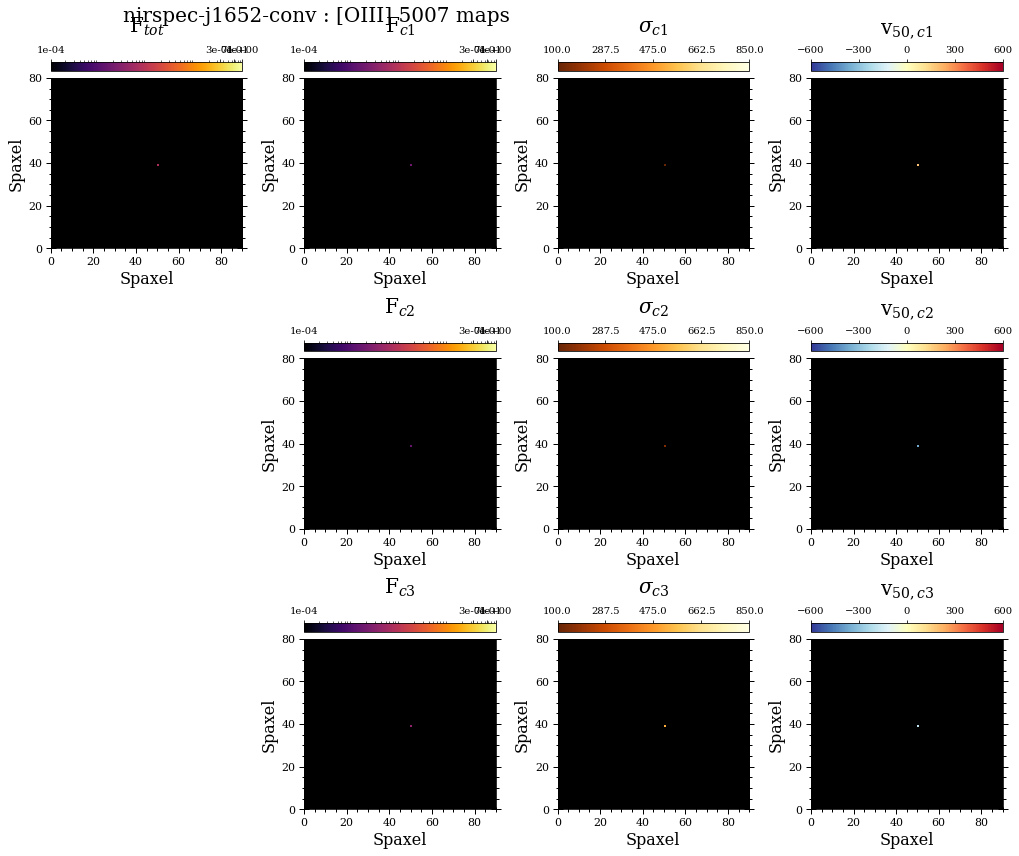

In [28]:
qpro = q3dpro.Q3Dpro(q3di, PLATESCALE=0.05, NOCONT=True)

do_kpc = False
saveFile = False
flx = [1e-4,1.]
qsocenter = None
pltarg = {'Ftot':flx,
          'Fci':flx,
          'Sig':[100,850],
          'v50':[-600,600],
          'fluxlog':True,}

#qpro.make_linemap('Hbeta',XYSTYLE=do_kpc,xyCenter=qsocenter,
#                  LINEVAC=False,SAVEDATA=saveFile,VMINMAX=pltarg,PLTNUM=1,CMAP='inferno')
#qpro.make_linemap('[OIII]4959',XYSTYLE=do_kpc,xyCenter=qsocenter,
#                  LINEVAC=False,SAVEDATA=saveFile,VMINMAX=pltarg,PLTNUM=1,CMAP='inferno')
qpro.make_linemap('[OIII]5007',XYSTYLE=do_kpc,xyCenter=qsocenter,
                  LINEVAC=False,SAVEDATA=saveFile,VMINMAX=pltarg,PLTNUM=1,CMAP='inferno')
#qpro.make_linemap('Halpha',XYSTYLE=do_kpc,xyCenter=qsocenter,
#                  LINEVAC=False,SAVEDATA=saveFile,VMINMAX=pltarg,PLTNUM=1,CMAP='inferno')